In [3]:
import os
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nibabel as nib
from nilearn import image as nimg
from nilearn import plotting as nplot
import bids
from nltools.file_reader import onsets_to_dm
from nltools.stats import regress, zscore
from nltools.data import Brain_Data, Design_Matrix
from nltools.stats import find_spikes 
from nilearn.plotting import view_img, glass_brain, plot_stat_map
from bids import BIDSLayout, BIDSValidator
import os
from pathlib import Path
from nilearn.glm.first_level import make_first_level_design_matrix
from nilearn.plotting import plot_design_matrix
from nilearn.glm.first_level import FirstLevelModel
from nilearn import plotting
from nilearn.plotting import plot_contrast_matrix
from nilearn.glm.first_level import FirstLevelModel
from nilearn import plotting
# creating mean img for plotting purposes 
from nilearn.image import mean_img
from nilearn.image import load_img
from nibabel import load
from nibabel.gifti import GiftiDataArray, GiftiImage
from nilearn.glm.first_level import run_glm as run_glm
from nilearn.glm import compute_contrast
import nilearn
fsaverage = nilearn.datasets.fetch_surf_fsaverage(mesh='fsaverage')

# Making results folder -- change to what this should actually be 
path = '/Volumes/Seagate Desktop Drive/kdata/'
os.chdir(path)
output_dir = Path.cwd() / "results" / "surface" / "first_level_results"
output_dir.mkdir(exist_ok=True, parents=True)
print(f"Output will be saved to: {output_dir}")

#isolating directory called layout_raw (for events.tsv files) -- will change depending on where data is stored / what computer we're running on
layout_raw = bids.BIDSLayout('/Volumes/Seagate Desktop Drive/kdata/', validate=True)

#isolating directory called layout (for fMRIprep derivatives) -- will change depending on where data is stored / what computer we're running on 
layout = bids.BIDSLayout('/Volumes/Seagate Desktop Drive/kdata/derivatives', validate=False,
                  config=['bids','derivatives'])
print(layout)

Output will be saved to: /Volumes/Seagate Desktop Drive/kdata/results/surface/first_level_results
BIDS Layout: ...esktop Drive/kdata/derivatives | Subjects: 58 | Sessions: 110 | Runs: 174


### Running first level for all subs

In [4]:
# needed for making design matrix 
# note: keep MNI files for isolating tr / frames bc easier to load 
def load_bids_events(layout,layout_raw, subject, run, session):
    '''Create a design_matrix instance from BIDS event file'''
    
    tr = 2.5 #put in manually bc get_tr wouldn't work?? 
    # change lines below -- can change to "mask", change task to "self-other"
    func_files = layout.get(subject=subject,
                        datatype='func', task='selfother',session = session,
                        desc='preproc',
                        space='MNI152NLin2009cAsym',
                        extension='nii.gz',
                       return_type='file')
    func_file = nimg.load_img(func_files[run])
    n_tr = func_file.shape[-1]

    onsets = pd.read_csv(layout_raw.get(subject=subject, suffix='events', session = session)[run].path)
    # line below is isolating the onset, duration, and trial type columns -- change according to events.tsv format 
    onsets_actual = onsets.iloc[:, [0,1,3]]
    onsets_actual.columns = ['onset', 'duration','trial_type'] # make sure this order matches with what's loaded in as "onsets_actua
    sampling_freq = 1/tr
    n_scans=n_tr
    return onsets_actual, tr, n_scans

from nilearn.datasets import fetch_icbm152_brain_gm_mask
from nilearn import plotting, masking
from nilearn.masking import _unmask_3d
from nilearn.maskers import nifti_spheres_masker
import nibabel as nib
from nibabel import Nifti1Image
from nilearn.image import resample_to_img 

sess = '01'
sub = '102'
fmri_imgs = layout.get(subject=sub,
            datatype='func', task='selfother',session = sess,
            desc='preproc',
            space='MNI152NLin2009cAsym',
            extension='nii.gz',
           return_type='file')

space_defining_image = masking.compute_brain_mask(fmri_imgs[0])

icbm_mask = fetch_icbm152_brain_gm_mask()
space_defining_image = masking.compute_brain_mask(fmri_imgs[0])

icbm_mask = resample_to_img(source_img=icbm_mask, target_img=space_defining_image, interpolation='nearest')

In [5]:
subjects = layout.get_subjects()

# subjects missing ses02:
# 102, 138, 145, 209, 221, 237 
subjects2 = []
subjects2 = subjects
#subjects2 = subjects
#testing second level (removing all subs with errors) 
del(subjects2[0]) #- 102 
del(subjects2[21]) #- 138 +1
del(subjects2[25]) #- 145 +1 
del(subjects2[32]) #- 209 +1 
del(subjects2[40]) #- 221 +1 
del(subjects2[50]) #- 237 +2 

subjects = layout.get_subjects()


In [ ]:
# to iterate through subjects ... 
#for sub in subjects 
from scipy.stats import norm

p001_unc = norm.isf(0.001)

file_lists = {"self-other": list(),
    "other-fix": list(),
     "self-fix": list(),
     "case-fix": list()
    }

firstlevel_plots = {"self-other": list(),
    "other-fix": list(),
     "self-fix": list(),
     "case-fix": list()
    }

nosessions = ['01','02']

for sess in nosessions: 

    if sess == '01':
        subject_list = subjects
    elif sess == '02':
        subject_list = subjects2
    
    for sub in subject_list: 
# change lines below -- can change to "mask", change task to "self-other" -- should match the same format as in the load_bids_events function
        fmri_imgs = layout.get(subject=sub,
                    datatype='func', task='selfother',session = sess,
                    desc='preproc',
                    space='MNI152NLin2009cAsym',
                    extension='nii.gz',
                   return_type='file')
        hrf_model = "spm" #canonical hrf 
        high_pass = 0.01 # The cutoff for the drift model is 0.01 Hz.

        confound_files = layout.get(subject=sub,
                        datatype='func', task='selfother',session = sess,
                        desc='confounds',
                       extension="tsv",
                       return_type='file')

# Select confounds -- set right now to just the 6 motion parameters but can add in more/less! 
       #32 confound_vars -- REMOVING GLOBAL SIGNAL 
        confound_vars = ['trans_x','trans_x_derivative1','trans_x_derivative1_power2','trans_x_power2',
                           'trans_y','trans_y_derivative1','trans_y_derivative1_power2','trans_y_power2',
                             'trans_z','trans_z_derivative1','trans_z_derivative1_power2','trans_z_power2',
                             'rot_x','rot_x_derivative1','rot_x_derivative1_power2','rot_x_power2',
                             'rot_y','rot_y_derivative1','rot_y_derivative1_power2','rot_y_power2',
                             'rot_z','rot_z_derivative1','rot_z_derivative1_power2','rot_z_power2',
                             'csf','csf_derivative1','csf_derivative1_power2','csf_power2',
                             'white_matter','white_matter_derivative1','white_matter_derivative1_power2','white_matter_power2'
                            ]

        final_confounds = confound_vars

        design_matrices = []

        print("Creating First Level Design matrix ... ")

        for idx, img in enumerate(fmri_imgs):
# Build experimental paradigm
            run = idx
            events,tr,n_scans = load_bids_events(layout,layout_raw, sub, run, sess)
    # Define the sampling times for the design matrix
            frame_times = np.arange(n_scans) * tr
            confound_file = confound_files[run]
            confound_df = pd.read_csv(confound_file, delimiter='\t')
            confound_df = confound_df[final_confounds]
            confound_df.fillna(0, inplace=True)
    # Build design matrix with the previously defined parameters
            design_matrix = make_first_level_design_matrix(
                frame_times,
                events,
                hrf_model=hrf_model,
                drift_model="polynomial",
                drift_order=3,
                add_regs=confound_df,
                add_reg_names=confound_vars,
                high_pass=high_pass,
            )
            design_matrix = design_matrix.iloc[:,0:11] # taking out constant intercept and adding in an intercept for each individual run
# this allows average voxel to vary across runs instead of assuming its constant 
            if idx == 0:
                design_matrix['intercept1'] = 1 
                design_matrix['intercept2'] = 0
                design_matrix['intercept3'] = 0
            elif idx == 1:
                design_matrix['intercept1'] = 0
                design_matrix['intercept2'] = 1 
                design_matrix['intercept3'] = 0
            else: 
                design_matrix['intercept1'] = 0
                design_matrix['intercept2'] = 0 
                design_matrix['intercept3'] = 1
    # put the design matrices in a list
            design_matrices.append(design_matrix)
    
# can visualize the design matrix with the line below 
#plot_design_matrix(design_matrices[1])
        print("First Level Design Matrix completed")

        contrast_matrix = np.eye(design_matrix.shape[1])
        basic_contrasts = {
            column: contrast_matrix[i]
            for i, column in enumerate(design_matrix.columns)
        }

        contrasts = {
            "self-other": (basic_contrasts["self"] - basic_contrasts["other"]),
            "self-fix": (basic_contrasts["self"] - basic_contrasts["fix"]),
            "other-fix": (basic_contrasts["other"] - basic_contrasts["fix"]),
            "case-fix": (basic_contrasts["case"] - basic_contrasts["fix"]),

        }

        print("Fitting first-level GLM ...")
        #added gm mask 
        fmri_glm = FirstLevelModel(mask_img = icbm_mask)
        #no gm mask 
        #fmri_glm = FirstLevelModel()
        
        fmri_glm = fmri_glm.fit(fmri_imgs, design_matrices=design_matrices)

        print("First-level completed!")

        mean_image = mean_img(fmri_imgs[0])

        print("Subject = " + sub)

    # Iterate on contrasts
        for contrast_id, contrast_val in contrasts.items():
    #print(f"\tcontrast id: {contrast_id}")
    # compute the contrasts
            outputs = fmri_glm.compute_contrast(contrast_val, output_type='all')
    # plot the contrasts as soon as they're generated
    # the display is overlaid on the mean fMRI image
    # a threshold of 3.0 is used, more sophisticated choices are possible
            fname = "/Volumes/Seagate Desktop Drive/kdata/results/first_level_results/sub" + sub + "_" + contrast_id + "_ses" + sess + ".nii.gz"
            # saving z-scores for plotting purposes  
            zname = "/Volumes/Seagate Desktop Drive/kdata/results/first_level_results/plotting/sub" + sub + "_" + contrast_id + "_ses" + sess + ".nii.gz"
            nib.save(outputs['effect_size'], fname)
            nib.save(outputs['z_score'], zname)
            plotting.plot_glass_brain(
                outputs['z_score'],
                threshold=p001_unc,
                display_mode="z",
                title=contrast_id,
            )
            plotting.show()
            file_lists[contrast_id].append(fname)
            firstlevel_plots[contrast_id].append(zname)

### Neural correlates of self-focused attention: self-fix for all subjects at baseline

In [70]:
# compiling all of session1 self-fix 
subject_sessions = {}

# Populate the dictionary
for file_path in file_lists['self-fix']:
    base_name = os.path.basename(file_path)
    parts = base_name.split('_')
    subject = parts[0]
    session = parts[-1].split('.')[0]
    if subject not in subject_sessions:
        subject_sessions[subject] = {}
    subject_sessions[subject][session] = file_path

# # isolate just self-fix session1 
self_v_fix_pre = [] 
selfvfix_pre_results = []
# # Loop through each subject and perform the extraction
for subject, sessions in subject_sessions.items():
    if 'ses01' in sessions:
#         # Load the NIfTI files
        ses01_img = nib.load(sessions['ses01'])
        
        # Append the result to the list
        selfvfix_pre_results.append((ses01_img))
        output_file = f'{subject}_selfvother_pre.nii.gz'
        nib.save(ses01_img, output_file)
        self_v_fix_pre.append([output_file])
        print(f'Appended result for {subject}')
    else:
        print(f'Subject {subject} does not have ses01 files')


Appended result for sub102
Appended result for sub103
Appended result for sub107
Appended result for sub109
Appended result for sub110
Appended result for sub111
Appended result for sub113
Appended result for sub114
Appended result for sub115
Appended result for sub117
Appended result for sub118
Appended result for sub119
Appended result for sub120
Appended result for sub122
Appended result for sub123
Appended result for sub125
Appended result for sub126
Appended result for sub127
Appended result for sub128
Appended result for sub129
Appended result for sub132
Appended result for sub136
Appended result for sub138
Appended result for sub139
Appended result for sub140
Appended result for sub143
Appended result for sub144
Appended result for sub145
Appended result for sub147
Appended result for sub150
Appended result for sub202
Appended result for sub204
Appended result for sub205
Appended result for sub206
Appended result for sub208
Appended result for sub209
Appended result for sub211
A

In [71]:
# second level 
selfvfix_sldm = np.ones(len(self_v_fix_pre))
selfvfix_sldm = pd.DataFrame(selfvfix_sldm, columns=['selfvfix'])

In [72]:
from nilearn.glm.second_level import SecondLevelModel 
second_level_input = selfvfix_pre_results
second_level_model = SecondLevelModel()
# plotting.plot_design_matrix(selfvfix_sldm, rescale=False)
# plt.title("Second-level Design Matrix", fontsize=20)
# plotting.show()

from nilearn.glm.second_level import SecondLevelModel

second_level_model = SecondLevelModel(n_jobs=2).fit(second_level_input, design_matrix=selfvfix_sldm)
contrast_val = [1]
outputs = second_level_model.compute_contrast(contrast_val, output_type='all')
stat_img = outputs['stat']

In [73]:
from nilearn.image import threshold_img

# Two types of strategies can be used from this threshold function
# Type 1: strategy used will be based on scoreatpercentile
threshold_percentile_img = threshold_img(
    stat_img, threshold="97%", cluster_threshold=10)


# Type 2: threshold strategy used will be based on image intensity
# Here, threshold value should be within the limits i.e. less than max value.
threshold_value_img = threshold_img(
    stat_img, threshold=p001_unc, cluster_threshold=10)

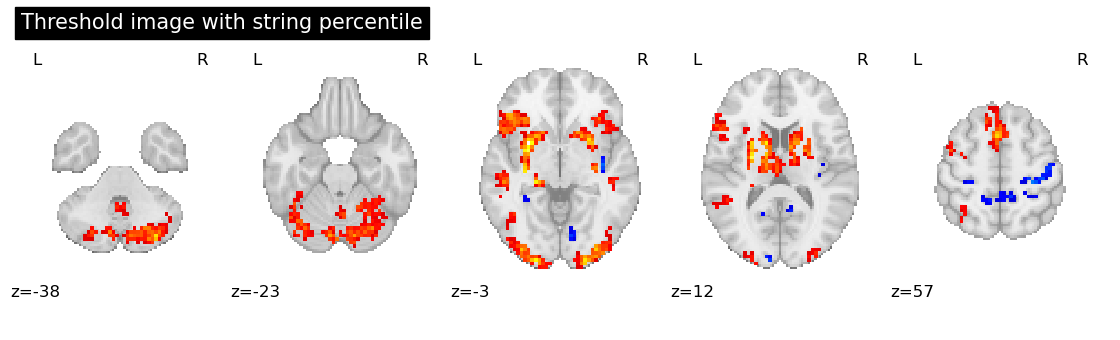

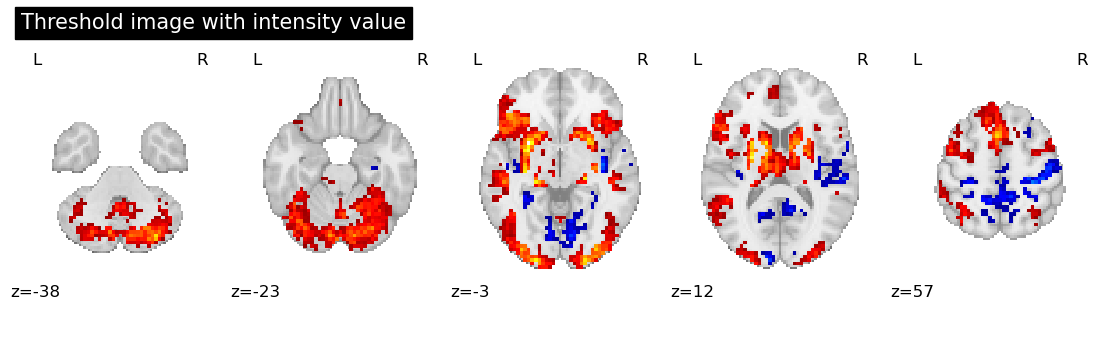

In [74]:
from nilearn import plotting

# Showing percentile threshold image
plotting.plot_stat_map(
    threshold_percentile_img,
    display_mode="z",
    cut_coords=5,
    title="Threshold image with string percentile",
    colorbar=False,
)

# Showing intensity threshold image
plotting.plot_stat_map(
    threshold_value_img,
    display_mode="z",
    cut_coords=5,
    title="Threshold image with intensity value",
    colorbar=False,
)

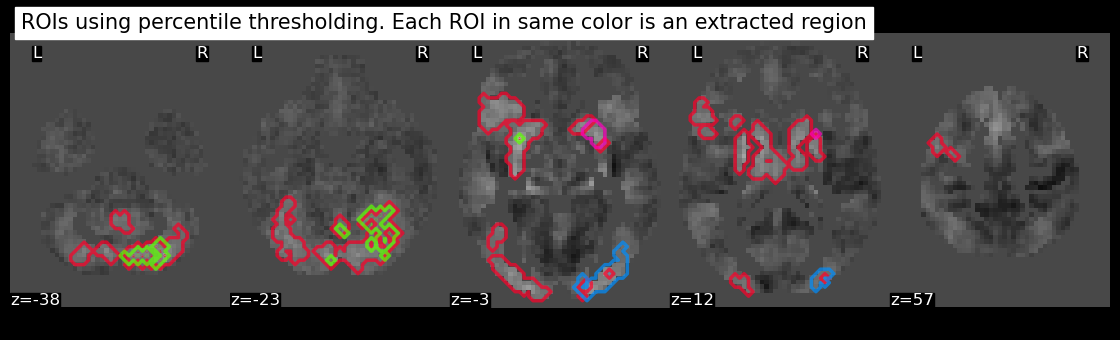

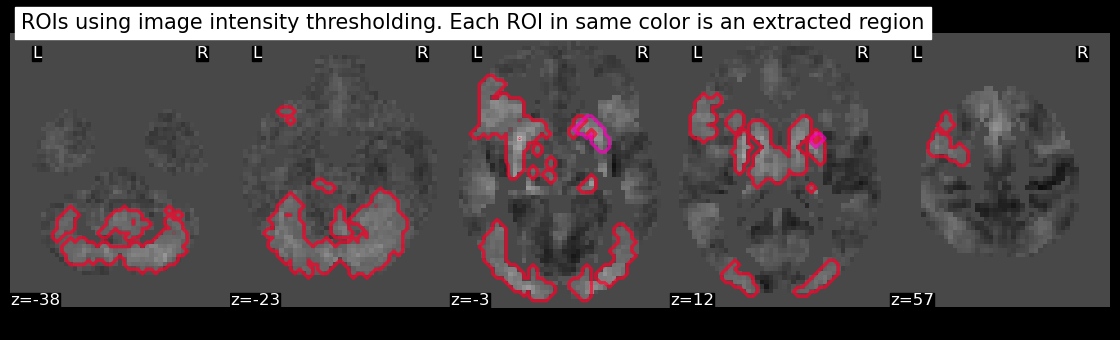

In [75]:
from nilearn.regions import connected_regions

regions_percentile_img, index_perc = connected_regions(
    threshold_percentile_img, min_region_size=1500
)

regions_value_img, index_val = connected_regions(
    threshold_value_img, min_region_size=1500
)

images = [regions_percentile_img, regions_value_img]
for image, strategy in zip(images, ["percentile", "image intensity"]):
    title = (
        f"ROIs using {strategy} thresholding. "
        "Each ROI in same color is an extracted region"
    )
    plotting.plot_prob_atlas(
        image,
        bg_img=stat_img,
        view_type="contours",
        display_mode="z",
        cut_coords=5,
        title=title,
    )
plotting.show()

In [33]:
results = regions_value_img.get_fdata()
regions_combo_img = results[:,:,:,0] + results[:,:,:,1]
# selfvfix_mask = resample_to_img(source_img=regions_combo_img, target_img=space_defining_image, interpolation='nearest')

regions_combo_img = (regions_combo_img > 0).astype(bool)
# sphere_mask = Nifti1Image(sphere_mask, space_defining_image.affine)

selfvfix_mask = Nifti1Image(regions_combo_img, space_defining_image.affine, header=regions_value_img.header)

### Neural correlates of self-focused attention: self-other for all subjects at baseline

In [7]:
# compiling all of session1 self-other
subject_sessions = {}

# Populate the dictionary
for file_path in file_lists['self-other']:
    base_name = os.path.basename(file_path)
    parts = base_name.split('_')
    subject = parts[0]
    session = parts[-1].split('.')[0]
    if subject not in subject_sessions:
        subject_sessions[subject] = {}
    subject_sessions[subject][session] = file_path

# # isolate just self-fix session1 
self_v_other_pre = [] 
selfvother_pre_results = []
# # Loop through each subject and perform the extraction
for subject, sessions in subject_sessions.items():
    if 'ses01' in sessions:
#         # Load the NIfTI files
        ses01_img = nib.load(sessions['ses01'])
        
        # Append the result to the list
        selfvother_pre_results.append((ses01_img))
        output_file = f'{subject}_selfvother_pre.nii.gz'
        nib.save(ses01_img, output_file)
        self_v_other_pre.append([output_file])
        print(f'Appended result for {subject}')
    else:
        print(f'Subject {subject} does not have ses01 files')

Appended result for sub102
Appended result for sub103
Appended result for sub107
Appended result for sub109
Appended result for sub110
Appended result for sub111
Appended result for sub113
Appended result for sub114
Appended result for sub115
Appended result for sub117
Appended result for sub118
Appended result for sub119
Appended result for sub120
Appended result for sub122
Appended result for sub123
Appended result for sub125
Appended result for sub126
Appended result for sub127
Appended result for sub128
Appended result for sub129
Appended result for sub132
Appended result for sub136
Appended result for sub138
Appended result for sub139
Appended result for sub140
Appended result for sub143
Appended result for sub144
Appended result for sub145
Appended result for sub147
Appended result for sub150
Appended result for sub202
Appended result for sub204
Appended result for sub205
Appended result for sub206
Appended result for sub208
Appended result for sub209
Appended result for sub211
A

In [8]:
# second level 
selfvother_sldm = np.ones(len(self_v_other_pre))
selfvother_sldm = pd.DataFrame(selfvother_sldm, columns=['selfvother'])

In [9]:
from nilearn.glm.second_level import SecondLevelModel 
second_level_input = selfvother_pre_results
second_level_model = SecondLevelModel()
# plotting.plot_design_matrix(selfvfix_sldm, rescale=False)
# plt.title("Second-level Design Matrix", fontsize=20)
# plotting.show()

from nilearn.glm.second_level import SecondLevelModel

second_level_model = SecondLevelModel(n_jobs=2).fit(second_level_input, design_matrix=selfvother_sldm)
contrast_val = [1]
outputs = second_level_model.compute_contrast(contrast_val, output_type='all')
bkg_img = outputs['stat']
stat_img = outputs['stat']

In [10]:
from nilearn.image import threshold_img

# Two types of strategies can be used from this threshold function
# Type 1: strategy used will be based on scoreatpercentile
threshold_percentile_img = threshold_img(
    stat_img, threshold="97%", cluster_threshold=10)

# Type 2: threshold strategy used will be based on image intensity
# Here, threshold value should be within the limits i.e. less than max value.
threshold_value_img = threshold_img(
    stat_img, threshold=p001_unc, cluster_threshold=10)

In [ ]:
from nilearn import plotting

# Showing percentile threshold image
plotting.plot_stat_map(
    threshold_percentile_img,
    display_mode="z",
    cut_coords=5,
    title="Threshold image with string percentile",
    colorbar=True,
)

# Showing intensity threshold image
plotting.plot_stat_map(
    threshold_value_img,
    display_mode="z",
    cut_coords=5,
    title="Threshold image with intensity value",
    colorbar=False,
)

In [ ]:
from nilearn.regions import connected_regions

regions_percentile_img, index_perc = connected_regions(
    threshold_percentile_img, min_region_size=1500
)

regions_value_img, index_val = connected_regions(
    threshold_value_img, min_region_size=1500
)

images = [regions_percentile_img, regions_value_img]
for image, strategy in zip(images, ["percentile", "image intensity"]):
    title = (
        f"ROIs using {strategy} thresholding. "
        "Each ROI in same color is an extracted region"
    )
    plotting.plot_prob_atlas(
        image,
        bg_img=stat_img,
        view_type="contours",
        display_mode="z",
        cut_coords=5,
        title=title,
    )
plotting.show()

In [13]:
# whole brain permutation testing for self-other clusters
from nilearn.glm.second_level import non_parametric_inference

out_dict_selfvother_pre = non_parametric_inference(
    second_level_input,
    design_matrix=selfvother_sldm,
    second_level_contrast=contrast_val,
    n_perm=10000,  # 500 for the sake of time. Ideally, this should be 10,000.
    two_sided_test=True,
    smoothing_fwhm=8.0,
    tfce=True,
    # mask=selfvfix_mask,
    threshold=0.001,
)

/Users/angelafang/opt/anaconda3/envs/nilearn/lib/python3.9/site-packages/nilearn/mass_univariate/permuted_least_squares.py:994: UserWarning: Data array used to create a new image contains 64-bit ints. This is likely due to creating the array with numpy and passing `int` as the `dtype`. Many tools such as FSL and SPM cannot deal with int64 in Nifti images, so for compatibility the data has been converted to int32.
  image.new_img_like(masker.mask_img_, metric_map),
/Users/angelafang/opt/anaconda3/envs/nilearn/lib/python3.9/site-packages/nilearn/masking.py:974: UserWarning: Data array used to create a new image contains 64-bit ints. This is likely due to creating the array with numpy and passing `int` as the `dtype`. Many tools such as FSL and SPM cannot deal with int64 in Nifti images, so for compatibility the data has been converted to int32.
  return new_img_like(mask_img, unmasked, affine)


In [20]:
# # method 3: neurosynth DMN mask: 
# from nilearn.image import resample_to_img 
# # We extract data from ROIs using nilearn's NiftiLabelsMasker
# from nilearn.maskers import NiftiLabelsMasker

# #import DMN Neurosynth mask:
# dmn_mask_raw = load_img('/Volumes/Seagate Desktop Drive/kdata/DMN masks/DMN.nii.gz')
# dmn_labels = resample_to_img(source_img=dmn_mask_raw, target_img=space_defining_image, interpolation='nearest')

# # First, initialize masker 
# masker = NiftiLabelsMasker(
#     dmn_labels, mask_img=space_defining_image
# )

# #average signal across DMN regions (PCC, mPFC, lTPJ, rTPJ)
# dmn_data = dmn_labels.get_fdata()
# binarized_data = (dmn_data > 0).astype(bool)
# dmn_avg_mask = Nifti1Image(binarized_data, dmn_labels.affine, header=dmn_labels.header)


In [ ]:
# Load your TFCE result NIfTI file (replace 'result_file.nii.gz' with your actual file path)
result_img = out_dict_selfvother_pre['tfce'] 
# Plotting the TFCE map
plotting.plot_glass_brain(result_img, threshold=0.001, title='TFCE Results', display_mode='ortho',plot_abs=False,
                       colorbar=True)

plt.show()

logp_max_tfce_img = out_dict_selfvother_pre['logp_max_tfce']

threshold = -np.log10(0.001)  # p<0.001 corrected

# Plotting the logp_max_tfce map
plotting.plot_glass_brain(logp_max_tfce_img, threshold=threshold, title='Log P Max TFCE', display_mode='ortho',plot_abs=False,
                        colorbar=True)

# Display the plot
plt.show()

t_img = out_dict_selfvother_pre['t']

threshold = -np.log10(0.001)  # p<0.001 corrected

# Plotting the logp_max_tfce map
plotting.plot_glass_brain(t_img, threshold=threshold, title='t-stat', display_mode='ortho',plot_abs=False,
                        colorbar=True)

# Display the plot
plt.show()

In [147]:
threshold = -np.log10(0.001)
threshold

3.0

In [331]:
# cluster summary table 

from nilearn.reporting import get_clusters_table
threshold = -np.log10(0.001)  # p<0.001 corrected

logp_max_tfce_img = out_dict_selfvother_pre['logp_max_tfce']

table = get_clusters_table(logp_max_tfce_img, threshold, 30)
print(table.to_latex())

thresh_tfce_img = out_dict_selfvother_pre['logp_max_tfce'].get_fdata()
thresh_tfce_img = (thresh_tfce_img >= 3)

thresh_tfce_img = Nifti1Image(thresh_tfce_img.astype(int), out_dict_selfvother_pre['logp_max_tfce'].affine, header=out_dict_selfvother_pre['logp_max_tfce'].header)

fname = "/Volumes/Seagate Desktop Drive/kdata/results/ms images/selfvsother_allsubs_binarized.nii.gz"
nib.save(thresh_tfce_img, fname)


\begin{tabular}{llrrrrl}
\toprule
 & Cluster ID & X & Y & Z & Peak Stat & Cluster Size (mm3) \\
\midrule
0 & 1 & 0.090004 & 34.556005 & 27.000000 & 4.000043 & 39651 \\
1 & 1a & -3.112996 & 31.353005 & 52.000000 & 3.699013 &  \\
2 & 1b & 6.496004 & 12.135005 & 67.000000 & 3.699013 &  \\
3 & 1c & -9.518996 & 8.932005 & 67.000000 & 3.397983 &  \\
\bottomrule
\end{tabular}



/Users/angelafang/opt/anaconda3/envs/nilearn/lib/python3.9/site-packages/nilearn/reporting/_get_clusters_table.py:104: UserWarning: Attention: At least one of the (sub)peaks falls outside of the cluster body. Identifying the nearest in-cluster voxel.
  warnings.warn(


#### plotting on surface 

In [ ]:
# threshold tfce image 

thresh_tfce_img = out_dict_selfvother_pre['logp_max_tfce'].get_fdata()
threshold_mask = (thresh_tfce_img >= 3)

# Extracting t_img data
t_img = out_dict_selfvother_pre['tfce'].get_fdata()

# Applying the threshold mask to t_img
filtered_t_img = np.where(threshold_mask, t_img, 0)  # Use 0 for values that do not surpass the threshold

# # Creating a new NIfTI image with the filtered data
filtered_t_img_nifti = Nifti1Image(filtered_t_img, 
                                   out_dict_selfvother_patientsvcontrols_pre['t'].affine, 
                                   header=out_dict_selfvother_patientsvcontrols_pre['t'].header)
# # Plotting the logp_max_tfce map
plotting.plot_glass_brain(filtered_t_img_nifti, threshold=0, title='Log P Max TFCE', display_mode='ortho',plot_abs=False,
                        colorbar=True)

fname = "/Volumes/Seagate Desktop Drive/kdata/results/ms images/selfvsother_allsubs_tfcevals.nii.gz"
nib.save(filtered_t_img_nifti, fname)

In [ ]:
from nilearn import datasets
fsaverage = datasets.fetch_surf_fsaverage()
from nilearn import surface

texture_rh = surface.vol_to_surf(out_dict_selfvother_pre['logp_max_tfce'], fsaverage.pial_right)

figure = plotting.plot_surf_stat_map(fsaverage.infl_right, 
                                     texture_rh, hemi='right',
                                     view='lateral',
                                     title='Surface right hemisphere',
                                     colorbar=True, threshold=3,
                                     bg_map=fsaverage.sulc_right)

figure = plotting.plot_surf_stat_map(fsaverage.infl_right, 
                                     texture_rh, hemi='right',
                                     view='medial',
                                     title='Surface right hemisphere',
                                     colorbar=True, threshold=3,
                                     bg_map=fsaverage.sulc_right)


texture_lh = surface.vol_to_surf(out_dict_selfvother_pre['logp_max_tfce'], fsaverage.pial_left)

figure = plotting.plot_surf_stat_map(fsaverage.infl_left, 
                                     texture_lh, hemi='left',
                                     view='lateral',
                                     title='Surface left hemisphere',
                                     colorbar=True, threshold=3,
                                     bg_map=fsaverage.sulc_left)

figure = plotting.plot_surf_stat_map(fsaverage.infl_left, 
                                     texture_lh, hemi='left',
                                     view='medial',
                                     title='Surface left hemisphere',
                                     colorbar=True, threshold=3,
                                     bg_map=fsaverage.sulc_left)

In [ ]:
# making self-other mask: 

stat_img = out_dict_selfvother_pre['logp_max_tfce']
threshold = -np.log10(0.001)  # 10% corrected

threshold_percentile_img = threshold_img(
    stat_img, threshold=threshold, cluster_threshold=10)

# Showing percentile threshold image
plotting.plot_stat_map(
    threshold_percentile_img,
    display_mode="z",
    cut_coords=5,
    title="Self-other neural correlates, FWE corrected 10%",
    colorbar=True,
)


In [ ]:
from nilearn.regions import connected_regions

regions_percentile_img, index_perc = connected_regions(
    threshold_percentile_img, min_region_size=1500
)

images = [regions_percentile_img]
for image, strategy in zip(images, ["percentile"]):
    title = (
        f"ROIs using {strategy} thresholding. "
        "Each ROI in same color is an extracted region"
    )
    plotting.plot_prob_atlas(
        image,
        bg_img=outputs['stat'],
        view_type="contours",
        display_mode="z",
        cut_coords=5,
        title=title,
    )
plotting.show()



In [27]:
#binarize mask 
data = regions_percentile_img.get_fdata()
data = np.squeeze(data, axis=-1)
binarized_data = (data > 0).astype(bool)
selfvother_mask = Nifti1Image(binarized_data, regions_percentile_img.affine, header=regions_percentile_img.header)
selfvother_mask.shape

(49, 61, 35)

### self-other @pre just patients

In [206]:
# Separate sessions and create sets for quick lookup
second_level_input = file_lists['self-other']
ses01_patients = {entry for entry in file_lists['self-other'] if entry.startswith('/Volumes/Seagate Desktop Drive/kdata/results/first_level_results/sub1') and entry.endswith('ses01.nii.gz')}
ses01_patient_indices = [i for i, entry in enumerate(file_lists['self-other']) if entry.startswith('/Volumes/Seagate Desktop Drive/kdata/results/first_level_results/sub1') and entry.endswith('ses01.nii.gz')]
ses01_patient_data = ([second_level_input[i] for i in ses01_patient_indices])

ses02_patients = {entry for entry in file_lists['self-other'] if entry.startswith('/Volumes/Seagate Desktop Drive/kdata/results/first_level_results/sub1') and entry.endswith('ses02.nii.gz')}
ses02_patient_indices = [i for i, entry in enumerate(file_lists['self-other']) if entry.startswith('/Volumes/Seagate Desktop Drive/kdata/results/first_level_results/sub1') and entry.endswith('ses02.nii.gz')]
ses02_patient_data = ([second_level_input[i] for i in ses02_patient_indices])

ses01_controls = {entry for entry in file_lists['self-other'] if entry.startswith('/Volumes/Seagate Desktop Drive/kdata/results/first_level_results/sub2') and entry.endswith('ses01.nii.gz')}
ses01_controls_indices = [i for i, entry in enumerate(file_lists['self-other']) if entry.startswith('/Volumes/Seagate Desktop Drive/kdata/results/first_level_results/sub2') and entry.endswith('ses01.nii.gz')]
ses01_controls_data = ([second_level_input[i] for i in ses01_controls_indices])

ses02_controls = {entry for entry in file_lists['self-other'] if entry.startswith('/Volumes/Seagate Desktop Drive/kdata/results/first_level_results/sub2') and entry.endswith('ses02.nii.gz')}
ses02_controls_indices = [i for i, entry in enumerate(file_lists['self-other']) if entry.startswith('/Volumes/Seagate Desktop Drive/kdata/results/first_level_results/sub2') and entry.endswith('ses02.nii.gz')]
ses02_controls_data = ([second_level_input[i] for i in ses02_controls_indices])

# controls_prevpost = np.concatenate((ses01_controls_data,ses02_controls_data))
# patients_prevpost = np.concatenate((ses01_patient_data,ses02_patient_data))
# pre = np.concatenate((ses01_patient_data,ses01_controls_data))
ses01_patient_data1 = ses01_patient_data 
len(ses01_patient_data1)

30

In [209]:
# second level 
selfvother_pts_sldm = np.ones(len(ses01_patient_data1))
selfvother_pts_sldm = pd.DataFrame(selfvother_pts_sldm, columns=['selfvother'])
contrast_val = [1]

In [210]:
# whole brain permutation testing for self-other clusters
from nilearn.glm.second_level import non_parametric_inference

out_dict_selfvother_pre_patients = non_parametric_inference(
    ses01_patient_data1,
    design_matrix=selfvother_pts_sldm,
    second_level_contrast=contrast_val,
    n_perm=10000,  # 500 for the sake of time. Ideally, this should be 10,000.
    two_sided_test=True,
    smoothing_fwhm=8.0,
    tfce=True,
    # mask=selfvfix_mask,
    threshold=0.001,
)

/Users/angelafang/opt/anaconda3/envs/nilearn/lib/python3.9/site-packages/nilearn/mass_univariate/permuted_least_squares.py:994: UserWarning: Data array used to create a new image contains 64-bit ints. This is likely due to creating the array with numpy and passing `int` as the `dtype`. Many tools such as FSL and SPM cannot deal with int64 in Nifti images, so for compatibility the data has been converted to int32.
  image.new_img_like(masker.mask_img_, metric_map),
/Users/angelafang/opt/anaconda3/envs/nilearn/lib/python3.9/site-packages/nilearn/masking.py:974: UserWarning: Data array used to create a new image contains 64-bit ints. This is likely due to creating the array with numpy and passing `int` as the `dtype`. Many tools such as FSL and SPM cannot deal with int64 in Nifti images, so for compatibility the data has been converted to int32.
  return new_img_like(mask_img, unmasked, affine)


In [ ]:
# Load your TFCE result NIfTI file (replace 'result_file.nii.gz' with your actual file path)
result_img = out_dict_selfvother_pre_patients['tfce'] 
# Plotting the TFCE map
plotting.plot_glass_brain(result_img, threshold=0.001, title='TFCE Results', display_mode='ortho',plot_abs=False,
                       colorbar=True)

plt.show()

logp_max_tfce_img = out_dict_selfvother_pre_patients['logp_max_tfce']

threshold = -np.log10(0.001)  # p<0.001 corrected

# Plotting the logp_max_tfce map
plotting.plot_glass_brain(logp_max_tfce_img, threshold=threshold, title='Log P Max TFCE', display_mode='ortho',plot_abs=False,
                        colorbar=True)

# Display the plot
plt.show()

In [217]:
# cluster summary table 

from nilearn.reporting import get_clusters_table
threshold = -np.log10(0.001)  # p<0.001 corrected

logp_max_tfce_img = out_dict_selfvother_pre_patients['logp_max_tfce']

table = get_clusters_table(logp_max_tfce_img, threshold, 30)
print(table.to_latex())

thresh_tfce_img = out_dict_selfvother_pre_patients['logp_max_tfce'].get_fdata()
thresh_tfce_img = (thresh_tfce_img >= 3)

thresh_tfce_img = Nifti1Image(thresh_tfce_img.astype(int), out_dict_selfvother_pre_patients['logp_max_tfce'].affine, header=out_dict_selfvother_pre_patients['logp_max_tfce'].header)

fname = "/Volumes/Seagate Desktop Drive/kdata/results/ms images/selfvsother_patients.nii.gz"
nib.save(thresh_tfce_img, fname)

\begin{tabular}{lrrrrrr}
\toprule
 & Cluster ID & X & Y & Z & Peak Stat & Cluster Size (mm3) \\
\midrule
0 & 1 & 0.090004 & 37.759006 & 17.000000 & 4.000043 & 20621 \\
\bottomrule
\end{tabular}



In [ ]:
from nilearn import datasets
fsaverage = datasets.fetch_surf_fsaverage()
from nilearn import surface

texture_rh = surface.vol_to_surf(out_dict_selfvother_pre_patients['logp_max_tfce'], fsaverage.pial_right)

figure = plotting.plot_surf_stat_map(fsaverage.infl_right, 
                                     texture_rh, hemi='right',
                                     view='lateral',
                                     title='Surface right hemisphere',
                                     colorbar=True, threshold=3,
                                     bg_map=fsaverage.sulc_right)

figure = plotting.plot_surf_stat_map(fsaverage.infl_right, 
                                     texture_rh, hemi='right',
                                     view='medial',
                                     title='Surface right hemisphere',
                                     colorbar=True, threshold=3,
                                     bg_map=fsaverage.sulc_right)


texture_lh = surface.vol_to_surf(out_dict_selfvother_pre_patients['logp_max_tfce'], fsaverage.pial_left)

figure = plotting.plot_surf_stat_map(fsaverage.infl_left, 
                                     texture_lh, hemi='left',
                                     view='lateral',
                                     title='Surface left hemisphere',
                                     colorbar=True, threshold=3,
                                     bg_map=fsaverage.sulc_left)

figure = plotting.plot_surf_stat_map(fsaverage.infl_left, 
                                     texture_lh, hemi='left',
                                     view='medial',
                                     title='Surface left hemisphere',
                                     colorbar=True, threshold=3,
                                     bg_map=fsaverage.sulc_left)

### self other @ pre just controls 

In [213]:
# second level 
selfvother_controls_sldm = np.ones(len(ses01_controls_data))
selfvother_controls_sldm = pd.DataFrame(selfvother_controls_sldm, columns=['selfvother'])
contrast_val = [1]

In [214]:
# whole brain permutation testing for self-other clusters
from nilearn.glm.second_level import non_parametric_inference

out_dict_selfvother_pre_controls = non_parametric_inference(
    ses01_controls_data,
    design_matrix=selfvother_controls_sldm,
    second_level_contrast=contrast_val,
    n_perm=10000,  # 500 for the sake of time. Ideally, this should be 10,000.
    two_sided_test=True,
    smoothing_fwhm=8.0,
    tfce=True,
    # mask=selfvfix_mask,
    threshold=0.001,
)

In [ ]:
# Load your TFCE result NIfTI file (replace 'result_file.nii.gz' with your actual file path)
result_img = out_dict_selfvother_pre_controls['tfce'] 
# Plotting the TFCE map
plotting.plot_glass_brain(result_img, threshold=0.001, title='TFCE Results', display_mode='ortho',plot_abs=False,
                       colorbar=True)

plt.show()

logp_max_tfce_img = out_dict_selfvother_pre_controls['logp_max_tfce']

threshold = -np.log10(0.001)  # p<0.001 corrected

# Plotting the logp_max_tfce map
plotting.plot_glass_brain(logp_max_tfce_img, threshold=threshold, title='Log P Max TFCE', display_mode='ortho',plot_abs=False,
                        colorbar=True)

# Display the plot
plt.show()

In [216]:
# cluster summary table 

from nilearn.reporting import get_clusters_table
threshold = -np.log10(0.001)  # p<0.001 corrected

logp_max_tfce_img = out_dict_selfvother_pre_controls['logp_max_tfce']

table = get_clusters_table(logp_max_tfce_img, threshold, 30)
print(table.to_latex())

thresh_tfce_img = out_dict_selfvother_pre_controls['logp_max_tfce'].get_fdata()
thresh_tfce_img = (thresh_tfce_img >= 3)

thresh_tfce_img = Nifti1Image(thresh_tfce_img.astype(int), out_dict_selfvother_pre_controls['logp_max_tfce'].affine, header=out_dict_selfvother_pre_controls['logp_max_tfce'].header)

fname = "/Volumes/Seagate Desktop Drive/kdata/results/ms images/selfvsother_controls.nii.gz"
nib.save(thresh_tfce_img, fname)

\begin{tabular}{llrrrrl}
\toprule
 & Cluster ID & X & Y & Z & Peak Stat & Cluster Size (mm3) \\
\midrule
0 & 1 & -6.315996 & 37.759006 & 2.000000 & 3.699013 & 4514 \\
1 & 1a & 6.496004 & 34.556005 & 7.000000 & 3.397983 &  \\
2 & 1b & 0.090004 & 44.165006 & 17.000000 & 3.221892 &  \\
3 & 1c & 6.496004 & 28.150005 & 17.000000 & 3.096953 &  \\
\bottomrule
\end{tabular}



In [ ]:
from nilearn import datasets
fsaverage = datasets.fetch_surf_fsaverage()
from nilearn import surface

texture_rh = surface.vol_to_surf(out_dict_selfvother_pre_controls['logp_max_tfce'], fsaverage.pial_right)

figure = plotting.plot_surf_stat_map(fsaverage.infl_right, 
                                     texture_rh, hemi='right',
                                     view='lateral',
                                     title='Surface right hemisphere',
                                     colorbar=True, threshold=3,
                                     bg_map=fsaverage.sulc_right,
                                     vmax=4.0)

figure = plotting.plot_surf_stat_map(fsaverage.infl_right, 
                                     texture_rh, hemi='right',
                                     view='medial',
                                     title='Surface right hemisphere',
                                     colorbar=True, threshold=3,
                                     bg_map=fsaverage.sulc_right,
                                     vmax=4.0)


texture_lh = surface.vol_to_surf(out_dict_selfvother_pre_controls['logp_max_tfce'], fsaverage.pial_left)

figure = plotting.plot_surf_stat_map(fsaverage.infl_left, 
                                     texture_lh, hemi='left',
                                     view='lateral',
                                     title='Surface left hemisphere',
                                     colorbar=True, threshold=3,
                                     bg_map=fsaverage.sulc_left,
                                     vmax=4.0)

figure = plotting.plot_surf_stat_map(fsaverage.infl_left,
                                     texture_lh, hemi='left',
                                     view='medial',
                                     title='Surface left hemisphere',
                                     colorbar=True, threshold=3,
                                     bg_map=fsaverage.sulc_left,
                                     vmax=4.0)

### self-other all subs mask + patients-controls diff at baseline (masked by self-other relevant regions for all subs) 

In [43]:
# Separate sessions and create sets for quick lookup
second_level_input = file_lists['self-other']
ses01_patients = {entry for entry in file_lists['self-other'] if entry.startswith('/Volumes/Seagate Desktop Drive/kdata/results/first_level_results/sub1') and entry.endswith('ses01.nii.gz')}
ses01_patient_indices = [i for i, entry in enumerate(file_lists['self-other']) if entry.startswith('/Volumes/Seagate Desktop Drive/kdata/results/first_level_results/sub1') and entry.endswith('ses01.nii.gz')]
ses01_patient_data = ([second_level_input[i] for i in ses01_patient_indices])

ses02_patients = {entry for entry in file_lists['self-other'] if entry.startswith('/Volumes/Seagate Desktop Drive/kdata/results/first_level_results/sub1') and entry.endswith('ses02.nii.gz')}
ses02_patient_indices = [i for i, entry in enumerate(file_lists['self-other']) if entry.startswith('/Volumes/Seagate Desktop Drive/kdata/results/first_level_results/sub1') and entry.endswith('ses02.nii.gz')]
ses02_patient_data = ([second_level_input[i] for i in ses02_patient_indices])

ses01_controls = {entry for entry in file_lists['self-other'] if entry.startswith('/Volumes/Seagate Desktop Drive/kdata/results/first_level_results/sub2') and entry.endswith('ses01.nii.gz')}
ses01_controls_indices = [i for i, entry in enumerate(file_lists['self-other']) if entry.startswith('/Volumes/Seagate Desktop Drive/kdata/results/first_level_results/sub2') and entry.endswith('ses01.nii.gz')]
ses01_controls_data = ([second_level_input[i] for i in ses01_controls_indices])

ses02_controls = {entry for entry in file_lists['self-other'] if entry.startswith('/Volumes/Seagate Desktop Drive/kdata/results/first_level_results/sub2') and entry.endswith('ses02.nii.gz')}
ses02_controls_indices = [i for i, entry in enumerate(file_lists['self-other']) if entry.startswith('/Volumes/Seagate Desktop Drive/kdata/results/first_level_results/sub2') and entry.endswith('ses02.nii.gz')]
ses02_controls_data = ([second_level_input[i] for i in ses02_controls_indices])

controls_prevpost = np.concatenate((ses01_controls_data,ses02_controls_data))
patients_prevpost = np.concatenate((ses01_patient_data,ses02_patient_data))
pre = np.concatenate((ses01_patient_data,ses01_controls_data))

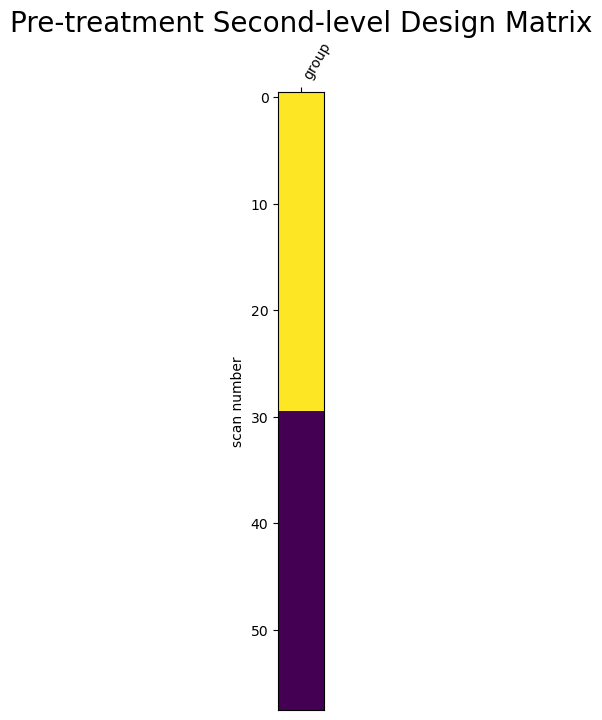

SecondLevelModel(n_jobs=2)

In [45]:
#pre/post second level design matrices (patients / controls sep) 

#pre  
# session variable
patients = []
session1 = np.ones(len(ses01_patients))
session2 = np.zeros(len(ses01_controls))
session2 = session2-1
patients = np.concatenate((session1,session2))
patients = np.expand_dims(patients, axis = -1)

# put all together 
pre_sldm = np.hstack((patients))


# plotting second level design matrix + adding column names for contrasts 
pre_sldm = pd.DataFrame(pre_sldm, columns=['group'])
pre_sldm.to_excel("/Users/angelafang/Desktop/pre_sldm.xlsx")

from nilearn.glm.second_level import SecondLevelModel 
plotting.plot_design_matrix(pre_sldm, rescale=False)
plt.title("Pre-treatment Second-level Design Matrix", fontsize=20)
plotting.show()

# second_level_model = SecondLevelModel(n_jobs=2,mask_img=selfvother_mask)
second_level_model = SecondLevelModel(n_jobs=2)

second_level_model.fit(pre.tolist(), design_matrix=pre_sldm)

In [46]:
contrast_matrix = np.eye(pre_sldm.shape[1])
basic_contrasts = {
    column: contrast_matrix[i]
    for i, column in enumerate(pre_sldm.columns)
    }

contrasts = {
    # "intercept": (basic_contrasts['intercept'])
    #"patients-controls,post-pre": (basic_contrasts["patients"]-basic_contrasts["controls"]+basic_contrasts["post"]-basic_contrasts["pre"]),
    # "post-pre": (basic_contrasts["post"]-basic_contrasts["pre"]),
     "patients-controls": (basic_contrasts["group"]),
    }      
contrasts

{'patients-controls': array([1.])}

In [ ]:
## 0.001 thresh 
for contrast_id, contrast_val in contrasts.items():
    outputs = second_level_model.compute_contrast(contrast_val, output_type='all')

    plotting.plot_glass_brain(
        outputs['z_score'],
        threshold=p001_unc,
        display_mode="ortho",
        title=[contrast_id+" p<0.001 thresh"],
        plot_abs=False,
        colorbar=True
        )
    plotting.show()

In [48]:
#w/out self-other mask -- whole brain @ baseline patients-controls 

contrast_val = contrast_val.tolist()
contrast_val

from nilearn.glm.second_level import non_parametric_inference

out_dict_selfvother_patientsvcontrols_pre = non_parametric_inference(
    pre.tolist(),
    design_matrix=pre_sldm,
    second_level_contrast=contrast_val,
    n_perm=10000,  # 500 for the sake of time. Ideally, this should be 10,000.
    two_sided_test=True,
    smoothing_fwhm=8.0,
    tfce=True,
    # mask=selfvother_mask,
    threshold=0.001,
)

/Users/angelafang/opt/anaconda3/envs/nilearn/lib/python3.9/site-packages/nilearn/mass_univariate/permuted_least_squares.py:994: UserWarning: Data array used to create a new image contains 64-bit ints. This is likely due to creating the array with numpy and passing `int` as the `dtype`. Many tools such as FSL and SPM cannot deal with int64 in Nifti images, so for compatibility the data has been converted to int32.
  image.new_img_like(masker.mask_img_, metric_map),
/Users/angelafang/opt/anaconda3/envs/nilearn/lib/python3.9/site-packages/nilearn/masking.py:974: UserWarning: Data array used to create a new image contains 64-bit ints. This is likely due to creating the array with numpy and passing `int` as the `dtype`. Many tools such as FSL and SPM cannot deal with int64 in Nifti images, so for compatibility the data has been converted to int32.
  return new_img_like(mask_img, unmasked, affine)


In [ ]:
# Load your TFCE result NIfTI file (replace 'result_file.nii.gz' with your actual file path)
result_img = out_dict_selfvother_patientsvcontrols_pre['t']

# Plotting the TFCE map
plotting.plot_glass_brain(result_img, threshold=0.001, title='TFCE Results', display_mode='ortho',plot_abs=False,
                       colorbar=True)

plt.show()

logp_max_tfce_img = out_dict_selfvother_patientsvcontrols_pre['logp_max_tfce']

threshold = -np.log10(0.001)  # 10% corrected

# Plotting the logp_max_tfce map
plotting.plot_glass_brain(logp_max_tfce_img, threshold=0, title='Log P Max TFCE', display_mode='ortho',plot_abs=False,
                        colorbar=True)

# Display the plot
plt.show()

In [ ]:
# threshold tfce image 

thresh_tfce_img = out_dict_selfvother_patientsvcontrols_pre['logp_max_tfce'].get_fdata()
threshold_mask = (thresh_tfce_img > 0)

# Extracting t_img data
t_img = out_dict_selfvother_patientsvcontrols_pre['tfce'].get_fdata()

# Applying the threshold mask to t_img
filtered_t_img = np.where(threshold_mask, t_img, 0)  # Use 0 for values that do not surpass the threshold

# # Creating a new NIfTI image with the filtered data
filtered_t_img_nifti = Nifti1Image(filtered_t_img, 
                                   out_dict_selfvother_patientsvcontrols_pre['t'].affine, 
                                   header=out_dict_selfvother_patientsvcontrols_pre['t'].header)
# # Plotting the logp_max_tfce map
plotting.plot_glass_brain(filtered_t_img_nifti, threshold=0, title='Log P Max TFCE', display_mode='ortho',plot_abs=False,
                        colorbar=True)

fname = "/Volumes/Seagate Desktop Drive/kdata/results/ms images/selfvsother_patientsvscontrols_baseline.nii.gz"
nib.save(filtered_t_img_nifti, fname)

In [219]:
# cluster summary table 

from nilearn.reporting import get_clusters_table
threshold = 0 # p<0.001 corrected

logp_max_tfce_img = out_dict_selfvother_patientsvcontrols_pre['logp_max_tfce']

table = get_clusters_table(logp_max_tfce_img, threshold, 30)
print(table.to_latex())

thresh_tfce_img = out_dict_selfvother_patientsvcontrols_pre['logp_max_tfce'].get_fdata()
thresh_tfce_img = (thresh_tfce_img >= 3)

thresh_tfce_img = Nifti1Image(thresh_tfce_img.astype(int), out_dict_selfvother_patientsvcontrols_pre['logp_max_tfce'].affine, header=out_dict_selfvother_patientsvcontrols_pre['logp_max_tfce'].header)

fname = "/Volumes/Seagate Desktop Drive/kdata/results/ms images/selfvsother_patientsvscontrols_baseline.nii.gz"
nib.save(thresh_tfce_img, fname)

\begin{tabular}{llrrrrl}
\toprule
 & Cluster ID & X & Y & Z & Peak Stat & Cluster Size (mm3) \\
\midrule
0 & 1 & 48.135005 & -39.112996 & 42.000000 & 1.129640 & 369588 \\
1 & 1a & 35.323005 & -64.736997 & 42.000000 & 1.012377 &  \\
2 & 1b & 0.090004 & -39.112996 & 57.000000 & 0.759245 &  \\
3 & 1c & 41.729005 & 34.556005 & 42.000000 & 0.745254 &  \\
4 & 2 & -54.360997 & 24.947005 & 17.000000 & 0.010193 & 3180 \\
5 & 3 & 9.699004 & -64.736997 & -53.000000 & 0.009261 & 7335 \\
6 & 3a & 6.496004 & -74.345997 & -48.000000 & 0.004145 &  \\
7 & 3b & -6.315996 & -71.142997 & -48.000000 & 0.003444 &  \\
8 & 3c & 22.511004 & -48.721996 & -58.000000 & 0.002395 &  \\
9 & 4 & 41.729005 & 44.165006 & -18.000000 & 0.005594 & 3180 \\
10 & 4a & 25.714005 & 44.165006 & -18.000000 & 0.005243 &  \\
11 & 5 & -41.548997 & 18.541005 & -13.000000 & 0.004847 & 5437 \\
12 & 5a & -35.142997 & 31.353005 & -3.000000 & 0.001218 &  \\
13 & 5b & -47.954997 & 2.526005 & -8.000000 & 0.000869 &  \\
14 & 5c & -54.360997

#### attempting to plot on the surface 

In [ ]:
from nilearn import datasets
fsaverage = datasets.fetch_surf_fsaverage()
from nilearn import surface

texture_rh = surface.vol_to_surf(filtered_t_img_nifti, fsaverage.pial_right)

figure = plotting.plot_surf_stat_map(fsaverage.infl_right, 
                                     texture_rh, hemi='right',
                                     view='lateral',
                                     title='Surface right hemisphere',
                                     colorbar=True, threshold=1000,
                                     bg_map=fsaverage.sulc_right)

figure = plotting.plot_surf_stat_map(fsaverage.infl_right, 
                                     texture_rh, hemi='right',
                                     view='medial',
                                     title='Surface right hemisphere',
                                     colorbar=True, threshold=1000,
                                     bg_map=fsaverage.sulc_right)


texture_lh = surface.vol_to_surf(filtered_t_img_nifti, fsaverage.pial_left)

figure = plotting.plot_surf_stat_map(fsaverage.infl_left, 
                                     texture_lh, hemi='left',
                                     view='lateral',
                                     title='Surface left hemisphere',
                                     colorbar=True, threshold=1000,
                                     bg_map=fsaverage.sulc_left)

figure = plotting.plot_surf_stat_map(fsaverage.infl_left, 
                                     texture_lh, hemi='left',
                                     view='medial',
                                     title='Surface left hemisphere',
                                     colorbar=True, threshold=1000,
                                     bg_map=fsaverage.sulc_left)

In [32]:
# w self-other mask 
contrast_val = contrast_val.tolist()
contrast_val

from nilearn.glm.second_level import non_parametric_inference

out_dict_selfvother_patientsvcontrols_pre = non_parametric_inference(
    pre.tolist(),
    design_matrix=pre_sldm,
    second_level_contrast=contrast_val,
    n_perm=10000,  # 500 for the sake of time. Ideally, this should be 10,000.
    two_sided_test=True,
    smoothing_fwhm=8.0,
    tfce=True,
    mask=selfvother_mask,
    threshold=0.001,
)

/Users/angelafang/opt/anaconda3/envs/nilearn/lib/python3.9/site-packages/nilearn/mass_univariate/permuted_least_squares.py:994: UserWarning: Data array used to create a new image contains 64-bit ints. This is likely due to creating the array with numpy and passing `int` as the `dtype`. Many tools such as FSL and SPM cannot deal with int64 in Nifti images, so for compatibility the data has been converted to int32.
  image.new_img_like(masker.mask_img_, metric_map),
/Users/angelafang/opt/anaconda3/envs/nilearn/lib/python3.9/site-packages/nilearn/masking.py:974: UserWarning: Data array used to create a new image contains 64-bit ints. This is likely due to creating the array with numpy and passing `int` as the `dtype`. Many tools such as FSL and SPM cannot deal with int64 in Nifti images, so for compatibility the data has been converted to int32.
  return new_img_like(mask_img, unmasked, affine)


In [ ]:
# Load your TFCE result NIfTI file (replace 'result_file.nii.gz' with your actual file path)
result_img = out_dict_selfvother_patientsvcontrols_pre['tfce']

# Plotting the TFCE map
plotting.plot_glass_brain(result_img, threshold=0.001, title='TFCE Results', display_mode='ortho',plot_abs=False,
                       colorbar=True)

plt.show()

logp_max_tfce_img = out_dict_selfvother_patientsvcontrols_pre['logp_max_tfce']

threshold = -np.log10(0.001)  # 10% corrected

# Plotting the logp_max_tfce map
plotting.plot_glass_brain(logp_max_tfce_img, threshold=0, title='Log P Max TFCE', display_mode='ortho',plot_abs=False,
                        colorbar=True)

# Display the plot
plt.show()

In [37]:
# cluster summary table 

from nilearn.reporting import get_clusters_table
threshold = -np.log10(0.001)  # p<0.001 corrected

logp_max_tfce_img = out_dict_selfvother_patientsvcontrols_pre['logp_max_tfce']

table = get_clusters_table(logp_max_tfce_img, 0, 10)
print(table.to_latex())

tfce_img = out_dict_selfvother_patientsvcontrols_pre['tfce']

table2 = get_clusters_table(tfce_img, 0, 10)
print(table.to_latex())

\begin{tabular}{llrrrrl}
\toprule
 & Cluster ID & X & Y & Z & Peak Stat & Cluster Size (mm3) \\
\midrule
0 & 1 & 3.293004 & 56.977006 & 7.000000 & 0.406979 & 15593 \\
1 & 1a & -6.315996 & 53.774006 & 7.000000 & 0.375555 &  \\
2 & 1b & -9.518996 & 44.165006 & -8.000000 & 0.135414 &  \\
3 & 1c & -9.518996 & 28.150005 & 37.000000 & 0.042245 &  \\
\bottomrule
\end{tabular}

\begin{tabular}{llrrrrl}
\toprule
 & Cluster ID & X & Y & Z & Peak Stat & Cluster Size (mm3) \\
\midrule
0 & 1 & 3.293004 & 56.977006 & 7.000000 & 0.406979 & 15593 \\
1 & 1a & -6.315996 & 53.774006 & 7.000000 & 0.375555 &  \\
2 & 1b & -9.518996 & 44.165006 & -8.000000 & 0.135414 &  \\
3 & 1c & -9.518996 & 28.150005 & 37.000000 & 0.042245 &  \\
\bottomrule
\end{tabular}



### Self-other correlates @ post 

In [343]:
# compiling all of session1 self-other
subject_sessions = {}

# Populate the dictionary
for file_path in file_lists['self-other']:
    base_name = os.path.basename(file_path)
    parts = base_name.split('_')
    subject = parts[0]
    session = parts[-1].split('.')[0]
    if subject not in subject_sessions:
        subject_sessions[subject] = {}
    subject_sessions[subject][session] = file_path

# # isolate just self-fix session1 
self_v_other_post = [] 
selfvother_post_results = []
# # Loop through each subject and perform the extraction
for subject, sessions in subject_sessions.items():
    if 'ses02' in sessions:
#         # Load the NIfTI files
        ses02_img = nib.load(sessions['ses02'])
        
        # Append the result to the list
        selfvother_post_results.append((ses02_img))
        output_file = f'{subject}_selfvother_post.nii.gz'
        nib.save(ses02_img, output_file)
        self_v_other_post.append([output_file])
        print(f'Appended result for {subject}')
    else:
        print(f'Subject {subject} does not have ses02 files')

Subject sub102 does not have ses02 files
Appended result for sub103
Appended result for sub107
Appended result for sub109
Appended result for sub110
Appended result for sub111
Appended result for sub113
Appended result for sub114
Appended result for sub115
Appended result for sub117
Appended result for sub118
Appended result for sub119
Appended result for sub120
Appended result for sub122
Appended result for sub123
Appended result for sub125
Appended result for sub126
Appended result for sub127
Appended result for sub128
Appended result for sub129
Appended result for sub132
Appended result for sub136
Subject sub138 does not have ses02 files
Appended result for sub139
Appended result for sub140
Appended result for sub143
Appended result for sub144
Subject sub145 does not have ses02 files
Appended result for sub147
Appended result for sub150
Appended result for sub202
Appended result for sub204
Appended result for sub205
Appended result for sub206
Appended result for sub208
Subject sub20

In [344]:
# second level 
selfvother_sldm = np.ones(len(self_v_other_post))
selfvother_sldm = pd.DataFrame(selfvother_sldm, columns=['selfvother'])

In [345]:
from nilearn.glm.second_level import SecondLevelModel 
second_level_input = selfvother_post_results
second_level_model = SecondLevelModel()
# plotting.plot_design_matrix(selfvfix_sldm, rescale=False)
# plt.title("Second-level Design Matrix", fontsize=20)
# plotting.show()

from nilearn.glm.second_level import SecondLevelModel

second_level_model = SecondLevelModel(n_jobs=2).fit(second_level_input, design_matrix=selfvother_sldm)
contrast_val = [1]
outputs = second_level_model.compute_contrast(contrast_val, output_type='all')
bkg_img = outputs['stat']
stat_img = outputs['stat']

In [354]:
selfvother_sldm

,selfvother
0,1.0
1,1.0
2,1.0
3,1.0
4,1.0
5,1.0
6,1.0
7,1.0
8,1.0
9,1.0


In [346]:
# whole brain permutation testing for self-other clusters
from nilearn.glm.second_level import non_parametric_inference

out_dict_selfvother_post = non_parametric_inference(
    second_level_input,
    design_matrix=selfvother_sldm,
    second_level_contrast=contrast_val,
    n_perm=10000,  # 500 for the sake of time. Ideally, this should be 10,000.
    two_sided_test=True,
    smoothing_fwhm=8.0,
    tfce=True,
    # mask=selfvfix_mask,
    threshold=0.001,
)

/Users/angelafang/opt/anaconda3/envs/nilearn/lib/python3.9/site-packages/nilearn/mass_univariate/permuted_least_squares.py:994: UserWarning: Data array used to create a new image contains 64-bit ints. This is likely due to creating the array with numpy and passing `int` as the `dtype`. Many tools such as FSL and SPM cannot deal with int64 in Nifti images, so for compatibility the data has been converted to int32.
  image.new_img_like(masker.mask_img_, metric_map),
/Users/angelafang/opt/anaconda3/envs/nilearn/lib/python3.9/site-packages/nilearn/masking.py:974: UserWarning: Data array used to create a new image contains 64-bit ints. This is likely due to creating the array with numpy and passing `int` as the `dtype`. Many tools such as FSL and SPM cannot deal with int64 in Nifti images, so for compatibility the data has been converted to int32.
  return new_img_like(mask_img, unmasked, affine)


In [ ]:
# Load your TFCE result NIfTI file (replace 'result_file.nii.gz' with your actual file path)
result_img = out_dict_selfvother_post['tfce'] 
# Plotting the TFCE map
plotting.plot_glass_brain(result_img, threshold=0.001, title='TFCE Results', display_mode='ortho',plot_abs=False,
                       colorbar=True)

plt.show()

logp_max_tfce_img = out_dict_selfvother_post['logp_max_tfce']

threshold = -np.log10(0.001)  # p<0.001 corrected

# Plotting the logp_max_tfce map
plotting.plot_glass_brain(logp_max_tfce_img, threshold=threshold, title='Log P Max TFCE', display_mode='ortho',plot_abs=False,
                        colorbar=True)

# Display the plot
plt.show()

t_img = out_dict_selfvother_post['t']

threshold = -np.log10(0.001)  # p<0.001 corrected

# Plotting the logp_max_tfce map
plotting.plot_glass_brain(t_img, threshold=threshold, title='t-stat', display_mode='ortho',plot_abs=False,
                        colorbar=True)

# Display the plot
plt.show()

In [ ]:
from nilearn import datasets
fsaverage = datasets.fetch_surf_fsaverage()
from nilearn import surface

texture_rh = surface.vol_to_surf(out_dict_selfvother_post['logp_max_tfce'], fsaverage.pial_right)

figure = plotting.plot_surf_stat_map(fsaverage.infl_right, 
                                     texture_rh, hemi='right',
                                     view='lateral',
                                     title='Surface right hemisphere',
                                     colorbar=True, threshold=3,
                                     bg_map=fsaverage.sulc_right)

figure = plotting.plot_surf_stat_map(fsaverage.infl_right, 
                                     texture_rh, hemi='right',
                                     view='medial',
                                     title='Surface right hemisphere',
                                     colorbar=True, threshold=3,
                                     bg_map=fsaverage.sulc_right)


texture_lh = surface.vol_to_surf(out_dict_selfvother_post['logp_max_tfce'], fsaverage.pial_left)

figure = plotting.plot_surf_stat_map(fsaverage.infl_left, 
                                     texture_lh, hemi='left',
                                     view='lateral',
                                     title='Surface left hemisphere',
                                     colorbar=True, threshold=3,
                                     bg_map=fsaverage.sulc_left)

figure = plotting.plot_surf_stat_map(fsaverage.infl_left, 
                                     texture_lh, hemi='left',
                                     view='medial',
                                     title='Surface left hemisphere',
                                     colorbar=True, threshold=3,
                                     bg_map=fsaverage.sulc_left)

#### self-other @ post: patients

In [355]:
# Separate sessions and create sets for quick lookup
second_level_input = file_lists['self-other']
ses01_patients = {entry for entry in file_lists['self-other'] if entry.startswith('/Volumes/Seagate Desktop Drive/kdata/results/first_level_results/sub1') and entry.endswith('ses01.nii.gz')}
ses01_patient_indices = [i for i, entry in enumerate(file_lists['self-other']) if entry.startswith('/Volumes/Seagate Desktop Drive/kdata/results/first_level_results/sub1') and entry.endswith('ses01.nii.gz')]
ses01_patient_data = ([second_level_input[i] for i in ses01_patient_indices])

ses02_patients = {entry for entry in file_lists['self-other'] if entry.startswith('/Volumes/Seagate Desktop Drive/kdata/results/first_level_results/sub1') and entry.endswith('ses02.nii.gz')}
ses02_patient_indices = [i for i, entry in enumerate(file_lists['self-other']) if entry.startswith('/Volumes/Seagate Desktop Drive/kdata/results/first_level_results/sub1') and entry.endswith('ses02.nii.gz')]
ses02_patient_data = ([second_level_input[i] for i in ses02_patient_indices])

ses01_controls = {entry for entry in file_lists['self-other'] if entry.startswith('/Volumes/Seagate Desktop Drive/kdata/results/first_level_results/sub2') and entry.endswith('ses01.nii.gz')}
ses01_controls_indices = [i for i, entry in enumerate(file_lists['self-other']) if entry.startswith('/Volumes/Seagate Desktop Drive/kdata/results/first_level_results/sub2') and entry.endswith('ses01.nii.gz')]
ses01_controls_data = ([second_level_input[i] for i in ses01_controls_indices])

ses02_controls = {entry for entry in file_lists['self-other'] if entry.startswith('/Volumes/Seagate Desktop Drive/kdata/results/first_level_results/sub2') and entry.endswith('ses02.nii.gz')}
ses02_controls_indices = [i for i, entry in enumerate(file_lists['self-other']) if entry.startswith('/Volumes/Seagate Desktop Drive/kdata/results/first_level_results/sub2') and entry.endswith('ses02.nii.gz')]
ses02_controls_data = ([second_level_input[i] for i in ses02_controls_indices])



In [357]:
# second level 
selfvother_pts_sldm = np.ones(len(ses02_patient_data))
selfvother_pts_sldm = pd.DataFrame(selfvother_pts_sldm, columns=['selfvother'])
contrast_val = [1]

In [360]:
# whole brain permutation testing for self-other clusters
from nilearn.glm.second_level import non_parametric_inference

out_dict_selfvother_post_patients = non_parametric_inference(
    ses02_patient_data,
    design_matrix=selfvother_pts_sldm,
    second_level_contrast=contrast_val,
    n_perm=10000,  # 500 for the sake of time. Ideally, this should be 10,000.
    two_sided_test=True,
    smoothing_fwhm=8.0,
    tfce=True,
    # mask=selfvfix_mask,
    threshold=0.001,
)

/Users/angelafang/opt/anaconda3/envs/nilearn/lib/python3.9/site-packages/nilearn/mass_univariate/permuted_least_squares.py:994: UserWarning: Data array used to create a new image contains 64-bit ints. This is likely due to creating the array with numpy and passing `int` as the `dtype`. Many tools such as FSL and SPM cannot deal with int64 in Nifti images, so for compatibility the data has been converted to int32.
  image.new_img_like(masker.mask_img_, metric_map),
/Users/angelafang/opt/anaconda3/envs/nilearn/lib/python3.9/site-packages/nilearn/masking.py:974: UserWarning: Data array used to create a new image contains 64-bit ints. This is likely due to creating the array with numpy and passing `int` as the `dtype`. Many tools such as FSL and SPM cannot deal with int64 in Nifti images, so for compatibility the data has been converted to int32.
  return new_img_like(mask_img, unmasked, affine)


In [ ]:
# Load your TFCE result NIfTI file (replace 'result_file.nii.gz' with your actual file path)
result_img = out_dict_selfvother_post_patients['tfce'] 
# Plotting the TFCE map
plotting.plot_glass_brain(result_img, threshold=0.001, title='TFCE Results', display_mode='ortho',plot_abs=False,
                       colorbar=True)

plt.show()

logp_max_tfce_img = out_dict_selfvother_post_patients['logp_max_tfce']

threshold = -np.log10(0.001)  # p<0.001 corrected

# Plotting the logp_max_tfce map
plotting.plot_glass_brain(logp_max_tfce_img, threshold=0, title='Log P Max TFCE', display_mode='ortho',plot_abs=False,
                        colorbar=True)

# Display the plot
plt.show()

t_img = out_dict_selfvother_post_patients['t']

threshold = -np.log10(0.001)  # p<0.001 corrected

# Plotting the logp_max_tfce map
plotting.plot_glass_brain(t_img, threshold=threshold, title='t-stat', display_mode='ortho',plot_abs=False,
                        colorbar=True)

# Display the plot
plt.show()

In [ ]:
from nilearn import datasets
fsaverage = datasets.fetch_surf_fsaverage()
from nilearn import surface

texture_rh = surface.vol_to_surf(out_dict_selfvother_post_patients['logp_max_tfce'], fsaverage.pial_right)

figure = plotting.plot_surf_stat_map(fsaverage.infl_right, 
                                     texture_rh, hemi='right',
                                     view='lateral',
                                     title='Surface right hemisphere',
                                     colorbar=True, threshold=3,
                                     bg_map=fsaverage.sulc_right)

figure = plotting.plot_surf_stat_map(fsaverage.infl_right, 
                                     texture_rh, hemi='right',
                                     view='medial',
                                     title='Surface right hemisphere',
                                     colorbar=True, threshold=3,
                                     bg_map=fsaverage.sulc_right)


texture_lh = surface.vol_to_surf(out_dict_selfvother_post_patients['logp_max_tfce'], fsaverage.pial_left)

figure = plotting.plot_surf_stat_map(fsaverage.infl_left, 
                                     texture_lh, hemi='left',
                                     view='lateral',
                                     title='Surface left hemisphere',
                                     colorbar=True, threshold=3,
                                     bg_map=fsaverage.sulc_left)

figure = plotting.plot_surf_stat_map(fsaverage.infl_left, 
                                     texture_lh, hemi='left',
                                     view='medial',
                                     title='Surface left hemisphere',
                                     colorbar=True, threshold=3,
                                     bg_map=fsaverage.sulc_left)

#### self-other @ post: controls

In [363]:
# Separate sessions and create sets for quick lookup
second_level_input = file_lists['self-other']
ses01_patients = {entry for entry in file_lists['self-other'] if entry.startswith('/Volumes/Seagate Desktop Drive/kdata/results/first_level_results/sub1') and entry.endswith('ses01.nii.gz')}
ses01_patient_indices = [i for i, entry in enumerate(file_lists['self-other']) if entry.startswith('/Volumes/Seagate Desktop Drive/kdata/results/first_level_results/sub1') and entry.endswith('ses01.nii.gz')]
ses01_patient_data = ([second_level_input[i] for i in ses01_patient_indices])

ses02_patients = {entry for entry in file_lists['self-other'] if entry.startswith('/Volumes/Seagate Desktop Drive/kdata/results/first_level_results/sub1') and entry.endswith('ses02.nii.gz')}
ses02_patient_indices = [i for i, entry in enumerate(file_lists['self-other']) if entry.startswith('/Volumes/Seagate Desktop Drive/kdata/results/first_level_results/sub1') and entry.endswith('ses02.nii.gz')]
ses02_patient_data = ([second_level_input[i] for i in ses02_patient_indices])

ses01_controls = {entry for entry in file_lists['self-other'] if entry.startswith('/Volumes/Seagate Desktop Drive/kdata/results/first_level_results/sub2') and entry.endswith('ses01.nii.gz')}
ses01_controls_indices = [i for i, entry in enumerate(file_lists['self-other']) if entry.startswith('/Volumes/Seagate Desktop Drive/kdata/results/first_level_results/sub2') and entry.endswith('ses01.nii.gz')]
ses01_controls_data = ([second_level_input[i] for i in ses01_controls_indices])

ses02_controls = {entry for entry in file_lists['self-other'] if entry.startswith('/Volumes/Seagate Desktop Drive/kdata/results/first_level_results/sub2') and entry.endswith('ses02.nii.gz')}
ses02_controls_indices = [i for i, entry in enumerate(file_lists['self-other']) if entry.startswith('/Volumes/Seagate Desktop Drive/kdata/results/first_level_results/sub2') and entry.endswith('ses02.nii.gz')]
ses02_controls_data = ([second_level_input[i] for i in ses02_controls_indices])


In [365]:
# second level 
selfvother_controls_sldm = np.ones(len(ses02_controls_data))
selfvother_controls_sldm = pd.DataFrame(selfvother_controls_sldm, columns=['selfvother'])
contrast_val = [1]

In [366]:
# whole brain permutation testing for self-other clusters
from nilearn.glm.second_level import non_parametric_inference

out_dict_selfvother_post_controls = non_parametric_inference(
    ses02_controls_data,
    design_matrix=selfvother_controls_sldm,
    second_level_contrast=contrast_val,
    n_perm=10000,  # 500 for the sake of time. Ideally, this should be 10,000.
    two_sided_test=True,
    smoothing_fwhm=8.0,
    tfce=True,
    # mask=selfvfix_mask,
    threshold=0.001,
)

In [ ]:
# Load your TFCE result NIfTI file (replace 'result_file.nii.gz' with your actual file path)
result_img = out_dict_selfvother_post_controls['tfce'] 
# Plotting the TFCE map
plotting.plot_glass_brain(result_img, threshold=0.001, title='TFCE Results', display_mode='ortho',plot_abs=False,
                       colorbar=True)

plt.show()

logp_max_tfce_img = out_dict_selfvother_post_controls['logp_max_tfce']

threshold = -np.log10(0.001)  # p<0.001 corrected

# Plotting the logp_max_tfce map
plotting.plot_glass_brain(logp_max_tfce_img, threshold=threshold, title='Log P Max TFCE', display_mode='ortho',plot_abs=False,
                        colorbar=True)

# Display the plot
plt.show()

t_img = out_dict_selfvother_post_patients['t']

threshold = -np.log10(0.001)  # p<0.001 corrected

# Plotting the logp_max_tfce map
plotting.plot_glass_brain(t_img, threshold=threshold, title='t-stat', display_mode='ortho',plot_abs=False,
                        colorbar=True)

# Display the plot
plt.show()

In [ ]:
from nilearn import datasets
fsaverage = datasets.fetch_surf_fsaverage()
from nilearn import surface

texture_rh = surface.vol_to_surf(out_dict_selfvother_post_controls['logp_max_tfce'], fsaverage.pial_right)

figure = plotting.plot_surf_stat_map(fsaverage.infl_right, 
                                     texture_rh, hemi='right',
                                     view='lateral',
                                     title='Surface right hemisphere',
                                     colorbar=True, threshold=3,
                                     bg_map=fsaverage.sulc_right)

figure = plotting.plot_surf_stat_map(fsaverage.infl_right, 
                                     texture_rh, hemi='right',
                                     view='medial',
                                     title='Surface right hemisphere',
                                     colorbar=True, threshold=3,
                                     bg_map=fsaverage.sulc_right)


texture_lh = surface.vol_to_surf(out_dict_selfvother_post_controls['logp_max_tfce'], fsaverage.pial_left)

figure = plotting.plot_surf_stat_map(fsaverage.infl_left, 
                                     texture_lh, hemi='left',
                                     view='lateral',
                                     title='Surface left hemisphere',
                                     colorbar=True, threshold=3,
                                     bg_map=fsaverage.sulc_left)

figure = plotting.plot_surf_stat_map(fsaverage.infl_left, 
                                     texture_lh, hemi='left',
                                     view='medial',
                                     title='Surface left hemisphere',
                                     colorbar=True, threshold=3,
                                     bg_map=fsaverage.sulc_left)

#### self-other @ post: patients-controls

In [369]:
# Separate sessions and create sets for quick lookup
second_level_input = file_lists['self-other']
ses01_patients = {entry for entry in file_lists['self-other'] if entry.startswith('/Volumes/Seagate Desktop Drive/kdata/results/first_level_results/sub1') and entry.endswith('ses01.nii.gz')}
ses01_patient_indices = [i for i, entry in enumerate(file_lists['self-other']) if entry.startswith('/Volumes/Seagate Desktop Drive/kdata/results/first_level_results/sub1') and entry.endswith('ses01.nii.gz')]
ses01_patient_data = ([second_level_input[i] for i in ses01_patient_indices])

ses02_patients = {entry for entry in file_lists['self-other'] if entry.startswith('/Volumes/Seagate Desktop Drive/kdata/results/first_level_results/sub1') and entry.endswith('ses02.nii.gz')}
ses02_patient_indices = [i for i, entry in enumerate(file_lists['self-other']) if entry.startswith('/Volumes/Seagate Desktop Drive/kdata/results/first_level_results/sub1') and entry.endswith('ses02.nii.gz')]
ses02_patient_data = ([second_level_input[i] for i in ses02_patient_indices])

ses01_controls = {entry for entry in file_lists['self-other'] if entry.startswith('/Volumes/Seagate Desktop Drive/kdata/results/first_level_results/sub2') and entry.endswith('ses01.nii.gz')}
ses01_controls_indices = [i for i, entry in enumerate(file_lists['self-other']) if entry.startswith('/Volumes/Seagate Desktop Drive/kdata/results/first_level_results/sub2') and entry.endswith('ses01.nii.gz')]
ses01_controls_data = ([second_level_input[i] for i in ses01_controls_indices])

ses02_controls = {entry for entry in file_lists['self-other'] if entry.startswith('/Volumes/Seagate Desktop Drive/kdata/results/first_level_results/sub2') and entry.endswith('ses02.nii.gz')}
ses02_controls_indices = [i for i, entry in enumerate(file_lists['self-other']) if entry.startswith('/Volumes/Seagate Desktop Drive/kdata/results/first_level_results/sub2') and entry.endswith('ses02.nii.gz')]
ses02_controls_data = ([second_level_input[i] for i in ses02_controls_indices])

controls_prevpost = np.concatenate((ses01_controls_data,ses02_controls_data))
patients_prevpost = np.concatenate((ses01_patient_data,ses02_patient_data))
post = np.concatenate((ses02_patient_data,ses02_controls_data))

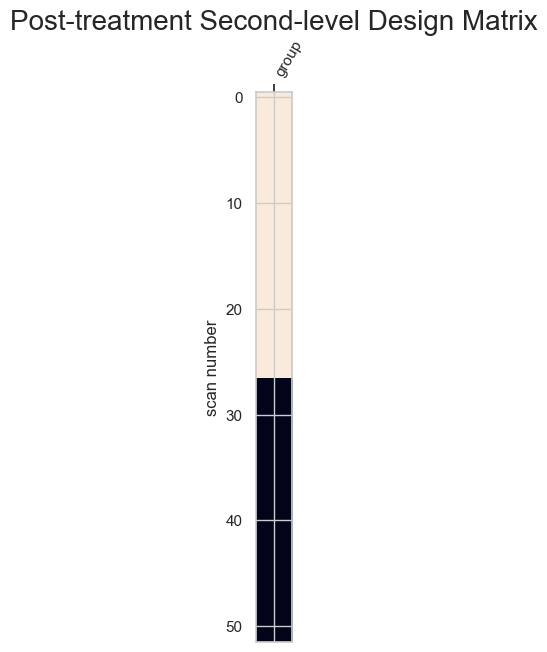

SecondLevelModel(n_jobs=2)

In [370]:
#pre/post second level design matrices (patients / controls sep) 

#pre  
# session variable
patients = []
session1 = np.ones(len(ses02_patients))
session2 = np.zeros(len(ses02_controls))
session2 = session2-1
patients = np.concatenate((session1,session2))
patients = np.expand_dims(patients, axis = -1)

# put all together 
post_sldm = np.hstack((patients))


# plotting second level design matrix + adding column names for contrasts 
post_sldm = pd.DataFrame(post_sldm, columns=['group'])
post_sldm.to_excel("/Users/angelafang/Desktop/post_sldm.xlsx")

from nilearn.glm.second_level import SecondLevelModel 
plotting.plot_design_matrix(post_sldm, rescale=False)
plt.title("Post-treatment Second-level Design Matrix", fontsize=20)
plotting.show()

# second_level_model = SecondLevelModel(n_jobs=2,mask_img=selfvother_mask)
second_level_model = SecondLevelModel(n_jobs=2)

second_level_model.fit(post.tolist(), design_matrix=post_sldm)

In [371]:
contrast_matrix = np.eye(post_sldm.shape[1])
basic_contrasts = {
    column: contrast_matrix[i]
    for i, column in enumerate(post_sldm.columns)
    }

contrasts = {
    # "intercept": (basic_contrasts['intercept'])
    #"patients-controls,post-pre": (basic_contrasts["patients"]-basic_contrasts["controls"]+basic_contrasts["post"]-basic_contrasts["pre"]),
    # "post-pre": (basic_contrasts["post"]-basic_contrasts["pre"]),
     "patients-controls": (basic_contrasts["group"]),
    }      
contrasts

{'patients-controls': array([1.])}

In [ ]:
## 0.001 thresh 
for contrast_id, contrast_val in contrasts.items():
    outputs = second_level_model.compute_contrast(contrast_val, output_type='all')

    plotting.plot_glass_brain(
        outputs['z_score'],
        threshold=p001_unc,
        display_mode="ortho",
        title=[contrast_id+" p<0.001 thresh"],
        plot_abs=False,
        colorbar=True
        )
    plotting.show()

In [373]:
contrast_val = contrast_val.tolist()
contrast_val

from nilearn.glm.second_level import non_parametric_inference

out_dict_selfvother_patientsvcontrols_post = non_parametric_inference(
    post.tolist(),
    design_matrix=post_sldm,
    second_level_contrast=contrast_val,
    n_perm=10000,  # 500 for the sake of time. Ideally, this should be 10,000.
    two_sided_test=True,
    smoothing_fwhm=8.0,
    tfce=True,
    # mask=selfvother_mask,
    threshold=0.001,
)

/Users/angelafang/opt/anaconda3/envs/nilearn/lib/python3.9/site-packages/nilearn/mass_univariate/permuted_least_squares.py:994: UserWarning: Data array used to create a new image contains 64-bit ints. This is likely due to creating the array with numpy and passing `int` as the `dtype`. Many tools such as FSL and SPM cannot deal with int64 in Nifti images, so for compatibility the data has been converted to int32.
  image.new_img_like(masker.mask_img_, metric_map),
/Users/angelafang/opt/anaconda3/envs/nilearn/lib/python3.9/site-packages/nilearn/masking.py:974: UserWarning: Data array used to create a new image contains 64-bit ints. This is likely due to creating the array with numpy and passing `int` as the `dtype`. Many tools such as FSL and SPM cannot deal with int64 in Nifti images, so for compatibility the data has been converted to int32.
  return new_img_like(mask_img, unmasked, affine)


In [ ]:
# Load your TFCE result NIfTI file (replace 'result_file.nii.gz' with your actual file path)
result_img = out_dict_selfvother_patientsvcontrols_post['tfce']

# Plotting the TFCE map
plotting.plot_glass_brain(result_img, threshold=0.001, title='TFCE Results', display_mode='ortho',plot_abs=False,
                       colorbar=True)

plt.show()

logp_max_tfce_img = out_dict_selfvother_patientsvcontrols_post['logp_max_tfce']

threshold = -np.log10(0.001)  # 10% corrected

# Plotting the logp_max_tfce map
plotting.plot_glass_brain(logp_max_tfce_img, threshold=0, title='Log P Max TFCE', display_mode='ortho',plot_abs=False,
                        colorbar=True)

# Display the plot
plt.show()

In [ ]:
# threshold tfce image 

thresh_tfce_img = out_dict_selfvother_patientsvcontrols_post['logp_max_tfce'].get_fdata()
threshold_mask = (thresh_tfce_img > 0)

# Extracting t_img data
t_img = out_dict_selfvother_patientsvcontrols_post['tfce'].get_fdata()

# Applying the threshold mask to t_img
filtered_t_img = np.where(threshold_mask, t_img, 0)  # Use 0 for values that do not surpass the threshold

# # Creating a new NIfTI image with the filtered data
filtered_t_img_nifti = Nifti1Image(filtered_t_img, 
                                   out_dict_selfvother_patientsvcontrols_pre['t'].affine, 
                                   header=out_dict_selfvother_patientsvcontrols_pre['t'].header)
# # Plotting the logp_max_tfce map
plotting.plot_glass_brain(filtered_t_img_nifti, threshold=0, title='Log P Max TFCE', display_mode='ortho',plot_abs=False,
                        colorbar=True)

fname = "/Volumes/Seagate Desktop Drive/kdata/results/ms images/selfvsother_patientsvscontrols_post.nii.gz"
nib.save(filtered_t_img_nifti, fname)

In [ ]:
from nilearn import datasets
fsaverage = datasets.fetch_surf_fsaverage()
from nilearn import surface

texture_rh = surface.vol_to_surf(filtered_t_img_nifti, fsaverage.pial_right)

figure = plotting.plot_surf_stat_map(fsaverage.infl_right, 
                                     texture_rh, hemi='right',
                                     view='lateral',
                                     title='Surface right hemisphere',
                                     colorbar=True, threshold=1000,
                                     bg_map=fsaverage.sulc_right)

figure = plotting.plot_surf_stat_map(fsaverage.infl_right, 
                                     texture_rh, hemi='right',
                                     view='medial',
                                     title='Surface right hemisphere',
                                     colorbar=True, threshold=1000,
                                     bg_map=fsaverage.sulc_right)


texture_lh = surface.vol_to_surf(filtered_t_img_nifti, fsaverage.pial_left)

figure = plotting.plot_surf_stat_map(fsaverage.infl_left, 
                                     texture_lh, hemi='left',
                                     view='lateral',
                                     title='Surface left hemisphere',
                                     colorbar=True, threshold=1000,
                                     bg_map=fsaverage.sulc_left)

figure = plotting.plot_surf_stat_map(fsaverage.infl_left, 
                                     texture_lh, hemi='left',
                                     view='medial',
                                     title='Surface left hemisphere',
                                     colorbar=True, threshold=1000,
                                     bg_map=fsaverage.sulc_left)

### self-fix all subs at baseline 

In [283]:
# Separate sessions and create sets for quick lookup
# compiling all of session1 self-other
subject_sessions = {}

# Populate the dictionary
for file_path in file_lists['self-fix']:
    base_name = os.path.basename(file_path)
    parts = base_name.split('_')
    subject = parts[0]
    session = parts[-1].split('.')[0]
    if subject not in subject_sessions:
        subject_sessions[subject] = {}
    subject_sessions[subject][session] = file_path

# # isolate just self-fix session1 
self_v_fix_pre = [] 
selfvfix_pre_results = []
# # Loop through each subject and perform the extraction
for subject, sessions in subject_sessions.items():
    if 'ses01' in sessions:
#         # Load the NIfTI files
        ses01_img = nib.load(sessions['ses01'])
        
        # Append the result to the list
        selfvfix_pre_results.append((ses01_img))
        output_file = f'{subject}_selfvfix_pre.nii.gz'
        nib.save(ses01_img, output_file)
        self_v_fix_pre.append([output_file])
        print(f'Appended result for {subject}')
    else:
        print(f'Subject {subject} does not have ses01 files')

Appended result for sub102
Appended result for sub103
Appended result for sub107
Appended result for sub109
Appended result for sub110
Appended result for sub111
Appended result for sub113
Appended result for sub114
Appended result for sub115
Appended result for sub117
Appended result for sub118
Appended result for sub119
Appended result for sub120
Appended result for sub122
Appended result for sub123
Appended result for sub125
Appended result for sub126
Appended result for sub127
Appended result for sub128
Appended result for sub129
Appended result for sub132
Appended result for sub136
Appended result for sub138
Appended result for sub139
Appended result for sub140
Appended result for sub143
Appended result for sub144
Appended result for sub145
Appended result for sub147
Appended result for sub150
Appended result for sub202
Appended result for sub204
Appended result for sub205
Appended result for sub206
Appended result for sub208
Appended result for sub209
Appended result for sub211
A

In [284]:
# second level 
selfvfix_sldm = np.ones(len(self_v_fix_pre))
selfvfix_sldm = pd.DataFrame(selfvfix_sldm, columns=['selfvother'])

In [285]:
from nilearn.glm.second_level import SecondLevelModel 
second_level_input = selfvfix_pre_results
second_level_model = SecondLevelModel()
# plotting.plot_design_matrix(selfvfix_sldm, rescale=False)
# plt.title("Second-level Design Matrix", fontsize=20)
# plotting.show()

from nilearn.glm.second_level import SecondLevelModel

second_level_model = SecondLevelModel(n_jobs=2).fit(second_level_input, design_matrix=selfvfix_sldm)
contrast_val = [1]
outputs = second_level_model.compute_contrast(contrast_val, output_type='all')
bkg_img = outputs['stat']
stat_img = outputs['stat']

In [ ]:
# whole brain permutation testing for self-other clusters
from nilearn.glm.second_level import non_parametric_inference

out_dict_selfvfix_pre_allsubs = non_parametric_inference(
    second_level_input,
    design_matrix=selfvfix_sldm,
    second_level_contrast=contrast_val,
    n_perm=10000,  # 500 for the sake of time. Ideally, this should be 10,000.
    two_sided_test=True,
    smoothing_fwhm=8.0,
    tfce=True,
    # mask=selfvfix_mask,
    threshold=0.001,
)

### self-other all subs + dmn mask at baseline

In [149]:
# DMN-MASKED SELF-OTHER BASELINE CORRELATES
from nilearn.glm.second_level import non_parametric_inference

out_dict_selfvother_pre_dmnmask = non_parametric_inference(
    second_level_input,
    design_matrix=selfvother_sldm,
    second_level_contrast=contrast_val,
    n_perm=10000,  # 500 for the sake of time. Ideally, this should be 10,000.
    two_sided_test=True,
    smoothing_fwhm=8.0,
    tfce=True,
    mask=dmn_avg_mask,
    threshold=0.001,
)

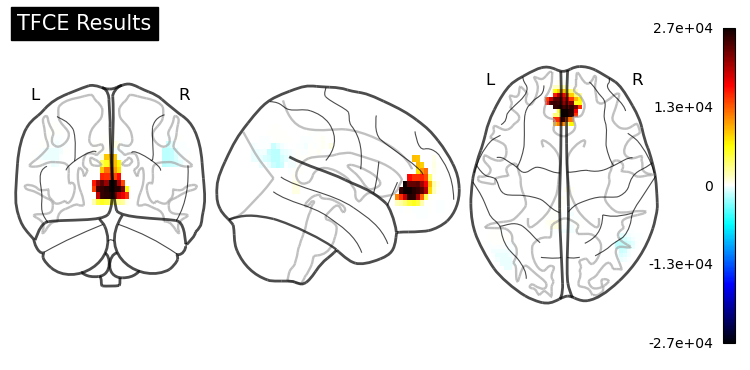

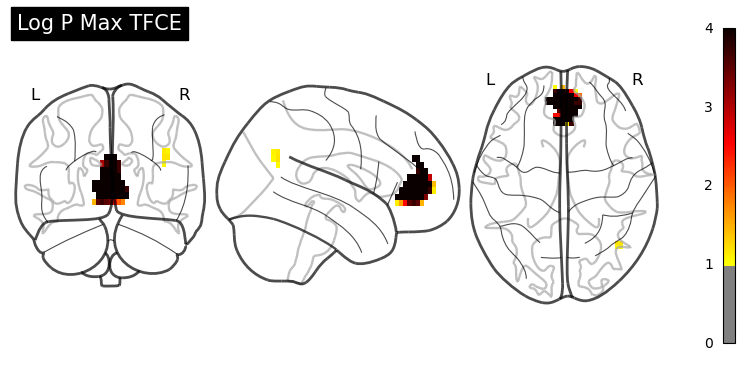

In [150]:
# Load your TFCE result NIfTI file (replace 'result_file.nii.gz' with your actual file path)
result_img = out_dict_selfvother_pre_dmnmask['tfce']

# Plotting the TFCE map
plotting.plot_glass_brain(result_img, threshold=0.001, title='TFCE Results', display_mode='ortho',plot_abs=False,
                       colorbar=True)

plt.show()

logp_max_tfce_img = out_dict_selfvother_pre_dmnmask['logp_max_tfce']

threshold = -np.log10(0.1)  # 10% corrected

# Plotting the logp_max_tfce map
plotting.plot_glass_brain(logp_max_tfce_img, threshold=threshold, title='Log P Max TFCE', display_mode='ortho',plot_abs=False,
                        colorbar=True)

# Display the plot
plt.show()

In [ ]:
# making self-other mask: 

stat_img = out_dict_selfvother_pre_dmnmask['logp_max_tfce']
threshold = -np.log10(0.1)  # 10% corrected

threshold_percentile_img = threshold_img(
    stat_img, threshold=threshold, cluster_threshold=10)

# Showing percentile threshold image
plotting.plot_stat_map(
    threshold_percentile_img,
    display_mode="z",
    cut_coords=5,
    title="Self-other neural correlates, FWE corrected 10%",
    colorbar=True,
)

In [ ]:
from nilearn.regions import connected_regions

regions_percentile_img, index_perc = connected_regions(
    threshold_percentile_img, min_region_size=1500
)

images = [regions_percentile_img]
for image, strategy in zip(images, ["percentile"]):
    title = (
        f"ROIs using {strategy} thresholding. "
        "Each ROI in same color is an extracted region"
    )
    plotting.plot_prob_atlas(
        image,
        bg_img=outputs['stat'],
        view_type="contours",
        display_mode="z",
        cut_coords=5,
        title=title,
    )
plotting.show()

### Aim2B: Examining neural correlates of SFA (self-other @baseline) in pre-post group analysis 

Includes applying the masks derived from self-other (or self-fix) @baseline for small volume cluster corrections (via TFCE) at second-level 

In [38]:
# subtracting ses02 - ses01 

# Dictionary to store the paths for each subject and session
subject_sessions = {}

# Populate the dictionary
for file_path in file_lists['self-other']:
    base_name = os.path.basename(file_path)
    parts = base_name.split('_')
    subject = parts[0]
    session = parts[-1].split('.')[0]
    if subject not in subject_sessions:
        subject_sessions[subject] = {}
    subject_sessions[subject][session] = file_path

# List to store the subtraction results
subtraction_results = []
postmpre_inputs = []
# Loop through each subject and perform the subtraction
for subject, sessions in subject_sessions.items():
    if 'ses01' in sessions and 'ses02' in sessions:
        # Load the NIfTI files
        ses01_img = nib.load(sessions['ses01'])
        ses02_img = nib.load(sessions['ses02'])
        
        # Extract the data
        ses01_data = ses01_img.get_fdata()
        ses02_data = ses02_img.get_fdata()
        result_data = []
        # Perform the subtraction
        result_data = ses02_data - ses01_data
        result_data = nib.Nifti1Image(result_data, ses02_img.affine, ses02_img.header)

        # Append the result to the list
        subtraction_results.append((result_data))
        output_file = f'{subject}_subtraction_result.nii.gz'
        nib.save(result_data, output_file)
        postmpre_inputs.append([output_file])
        print(f'Appended result for {subject}')
    else:
        print(f'Subject {subject} does not have both ses01 and ses02 files')


Subject sub102 does not have both ses01 and ses02 files
Appended result for sub103
Appended result for sub107
Appended result for sub109
Appended result for sub110
Appended result for sub111
Appended result for sub113
Appended result for sub114
Appended result for sub115
Appended result for sub117
Appended result for sub118
Appended result for sub119
Appended result for sub120
Appended result for sub122
Appended result for sub123
Appended result for sub125
Appended result for sub126
Appended result for sub127
Appended result for sub128
Appended result for sub129
Appended result for sub132
Appended result for sub136
Subject sub138 does not have both ses01 and ses02 files
Appended result for sub139
Appended result for sub140
Appended result for sub143
Appended result for sub144
Subject sub145 does not have both ses01 and ses02 files
Appended result for sub147
Appended result for sub150
Appended result for sub202
Appended result for sub204
Appended result for sub205
Appended result for su

In [39]:
#second level design matrix for postmpre_inputs (ses02 - ses01) 

# patient-controls group variable 
subjects = []
group1 = []
for sub in subjects2: 
    if int(sub) < 200:
        group_as = 1
    else:
        group_as = -1
    group1.append(group_as)
subjects = np.expand_dims(group1, axis = -1)


second_level_design_matrix = np.hstack((subjects))

# deleted out subs who didn't have second session (n = 5)

second_level_design_matrix
second_level_design_matrix = pd.DataFrame(second_level_design_matrix, columns=['group'])
#second_level_design_matrix.to_excel("/Users/angelafang/Desktop/test.xlsx")
second_level_design_matrix.shape

(52, 1)

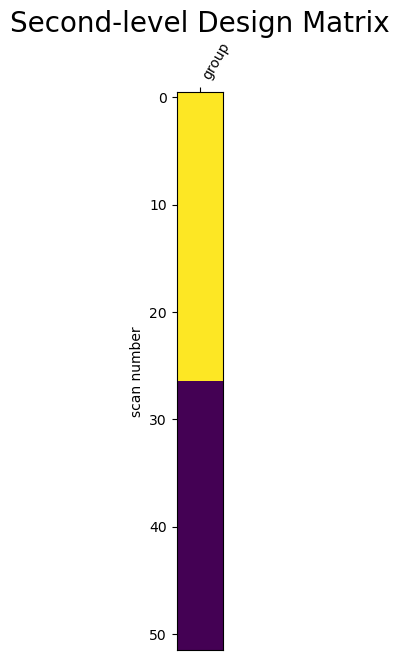

SecondLevelModel(n_jobs=2)

In [40]:
from nilearn.glm.second_level import SecondLevelModel 
second_level_input = subtraction_results
second_level_input
second_level_design_matrix
second_level_model = SecondLevelModel()
plotting.plot_design_matrix(second_level_design_matrix, rescale=False)
plt.title("Second-level Design Matrix", fontsize=20)
plotting.show()

from nilearn.glm.second_level import SecondLevelModel

# second_level_model = SecondLevelModel(mask_img=selfvfix_mask,n_jobs=2)
second_level_model = SecondLevelModel(n_jobs=2)
second_level_model.fit(second_level_input, design_matrix=second_level_design_matrix)

In [41]:
#Making contrasts! 
contrast_matrix = np.eye(second_level_design_matrix.shape[1])
basic_contrasts = {
    column: contrast_matrix[i]
    for i, column in enumerate(second_level_design_matrix.columns)
    }

contrasts = {
    # "intercept": (basic_contrasts['intercept'])
    #"patients-controls,post-pre": (basic_contrasts["patients"]-basic_contrasts["controls"]+basic_contrasts["post"]-basic_contrasts["pre"]),
    # "post-pre": (basic_contrasts["post"]-basic_contrasts["pre"]),
     "patients-controls": (basic_contrasts["group"]),
    }      
contrasts

# from nilearn.plotting import plot_contrast_matrix
# for key, values in contrasts.items():
#     plot_contrast_matrix(values, design_matrix=second_level_design_matrix)
#     plt.suptitle(key)
# plt.show()

{'patients-controls': array([1.])}

In [ ]:
 # Iterate on contrasts
for contrast_id, contrast_val in contrasts.items():
    outputs = second_level_model.compute_contrast(contrast_val, output_type='all')

    fname = "/Volumes/Seagate Desktop Drive/kdata/results/second_level_results/sub" + sub + "_" + contrast_id + ".nii.gz"
    # saving z-scores for plotting purposes  
    zname = "/Volumes/Seagate Desktop Drive/kdata/results/second_level_results/plotting/sub" + sub + "_" + contrast_id + ".nii.gz"
    nib.save(outputs['effect_size'], fname)
    nib.save(outputs['z_score'], zname)
    plotting.plot_glass_brain(
        outputs['z_score'],
        threshold=p001_unc,
        display_mode="ortho",
        title=[contrast_id+" p<0.001 thresh"],
        plot_abs=False,
        colorbar=True
        )
    plotting.show()

In [127]:
# contrast_val = contrasts['patients-controls,post-pre'].T
contrast_val = contrast_val.tolist()
contrast_val

[1.0]

### Aim2B Self-other mask 

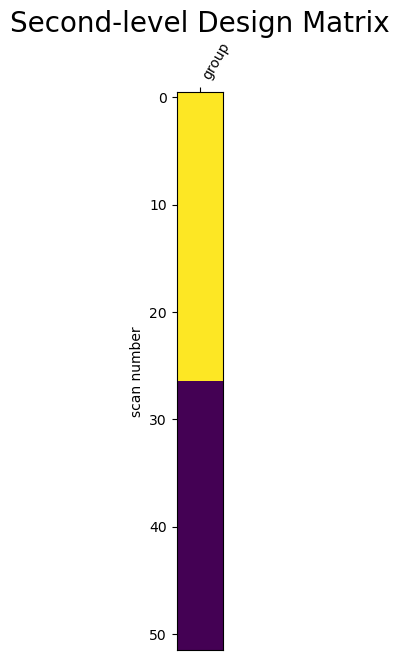

/Users/angelafang/opt/anaconda3/envs/nilearn/lib/python3.9/site-packages/nilearn/glm/_utils.py:346: RuntimeWarning: divide by zero encountered in divide
  return np.where(X <= 0, 0, 1.0 / X)
/Users/angelafang/opt/anaconda3/envs/nilearn/lib/python3.9/site-packages/nilearn/plotting/displays/_slicers.py:438: UserWarning: empty mask
  xmin_, xmax_, ymin_, ymax_, zmin_, zmax_ = get_mask_bounds(


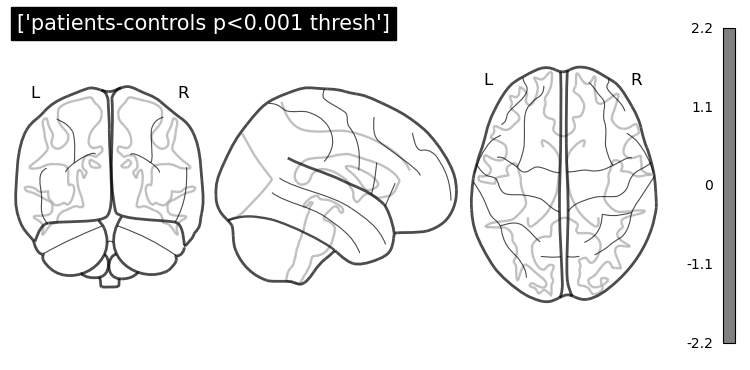

In [166]:
# fitting second level model 
from nilearn.glm.second_level import SecondLevelModel 
second_level_input = subtraction_results
second_level_input
second_level_design_matrix
second_level_model = SecondLevelModel()
plotting.plot_design_matrix(second_level_design_matrix, rescale=False)
plt.title("Second-level Design Matrix", fontsize=20)
plotting.show()

from nilearn.glm.second_level import SecondLevelModel

# second_level_model = SecondLevelModel(mask_img=selfvfix_mask,n_jobs=2)
second_level_model = SecondLevelModel(n_jobs=2, mask_img=dmn_avg_mask)
second_level_model.fit(second_level_input, design_matrix=second_level_design_matrix)

## 0.001 thresh 
for contrast_id, contrast_val in contrasts.items():
    outputs = second_level_model.compute_contrast(contrast_val, output_type='all')

    fname = "/Volumes/Seagate Desktop Drive/kdata/results/second_level_results/sub" + sub + "_" + contrast_id + ".nii.gz"
    # saving z-scores for plotting purposes  
    zname = "/Volumes/Seagate Desktop Drive/kdata/results/second_level_results/plotting/sub" + sub + "_" + contrast_id + ".nii.gz"
    nib.save(outputs['effect_size'], fname)
    nib.save(outputs['z_score'], zname)
    plotting.plot_glass_brain(
        outputs['z_score'],
        threshold=p001_unc,
        display_mode="ortho",
        title=[contrast_id+" p<0.001 thresh"],
        plot_abs=False,
        colorbar=True
        )
    plotting.show()

In [128]:
from nilearn.glm.second_level import non_parametric_inference

out_dict_selfvother_secondlevel_mask = non_parametric_inference(
    second_level_input,
    design_matrix=second_level_design_matrix,
    second_level_contrast=contrast_val,
    n_perm=10000,  # 500 for the sake of time. Ideally, this should be 10,000.
    two_sided_test=True,
    smoothing_fwhm=8.0,
    tfce=True,
    mask=selfvother_mask,
    threshold=0.001,
)

/Users/angelafang/opt/anaconda3/envs/nilearn/lib/python3.9/site-packages/nilearn/mass_univariate/permuted_least_squares.py:994: UserWarning: Data array used to create a new image contains 64-bit ints. This is likely due to creating the array with numpy and passing `int` as the `dtype`. Many tools such as FSL and SPM cannot deal with int64 in Nifti images, so for compatibility the data has been converted to int32.
  image.new_img_like(masker.mask_img_, metric_map),
/Users/angelafang/opt/anaconda3/envs/nilearn/lib/python3.9/site-packages/nilearn/masking.py:974: UserWarning: Data array used to create a new image contains 64-bit ints. This is likely due to creating the array with numpy and passing `int` as the `dtype`. Many tools such as FSL and SPM cannot deal with int64 in Nifti images, so for compatibility the data has been converted to int32.
  return new_img_like(mask_img, unmasked, affine)


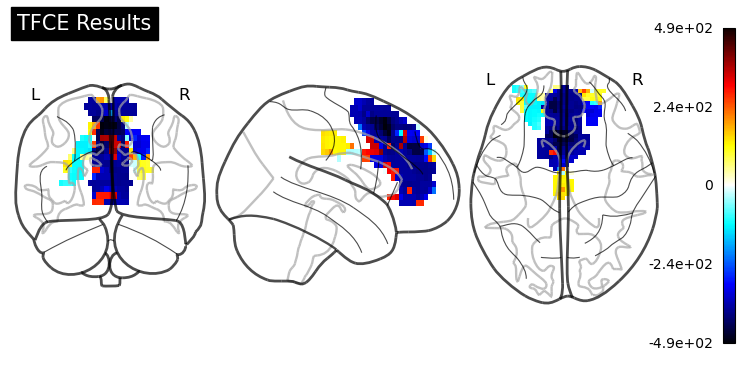

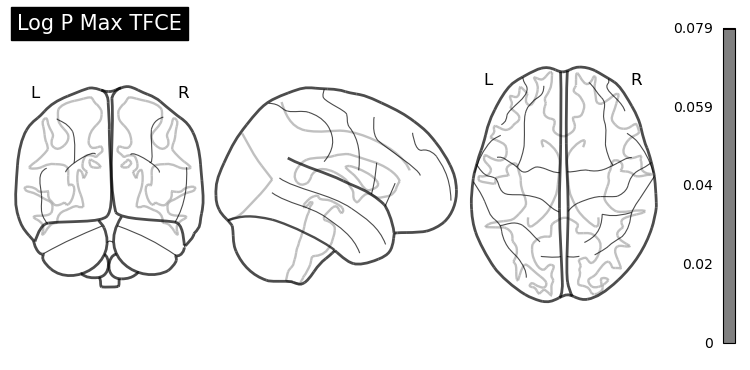

In [133]:
#plotting 
result_img = out_dict_selfvother_secondlevel_mask['tfce']
plotting.plot_glass_brain(result_img, threshold=0.001, title='TFCE Results',display_mode='ortho',plot_abs=False,colorbar=True)
plt.show()#threshold=0

logp_max_tfce_img = out_dict_selfvother_secondlevel_mask['logp_max_tfce']
threshold=-np.log10(0.1)
plotting.plot_glass_brain(logp_max_tfce_img, threshold=threshold, title='Log P Max TFCE',display_mode='ortho',plot_abs=False,colorbar=True)
plt.show()

### Aim2B: Self-other neural correlates + DMN mask -- never ran 

In [ ]:
from nilearn.glm.second_level import non_parametric_inference

out_dict_selfvother_secondlevel_mask = non_parametric_inference(
    second_level_input,
    design_matrix=second_level_design_matrix,
    second_level_contrast=contrast_val,
    n_perm=10000,  # 500 for the sake of time. Ideally, this should be 10,000.
    two_sided_test=True,
    smoothing_fwhm=8.0,
    tfce=True,
    mask=selfvother_mask,
    threshold=0.001,
)

### Aim2B: Self-fix mask 

In [37]:
#TFCE - non-parametric cluster correction

from nilearn.glm.second_level import non_parametric_inference

out_dict_selfvfix_mask = non_parametric_inference(
    second_level_input,
    design_matrix=second_level_design_matrix,
    second_level_contrast=contrast_val,
    n_perm=10000,  # 500 for the sake of time. Ideally, this should be 10,000.
    two_sided_test=True,
    smoothing_fwhm=8.0,
    tfce=True,
    mask=selfvfix_mask,
    threshold=0.001,
)

/Users/angelafang/opt/anaconda3/envs/nilearn/lib/python3.9/site-packages/nilearn/mass_univariate/permuted_least_squares.py:994: UserWarning: Data array used to create a new image contains 64-bit ints. This is likely due to creating the array with numpy and passing `int` as the `dtype`. Many tools such as FSL and SPM cannot deal with int64 in Nifti images, so for compatibility the data has been converted to int32.
  image.new_img_like(masker.mask_img_, metric_map),
/Users/angelafang/opt/anaconda3/envs/nilearn/lib/python3.9/site-packages/nilearn/masking.py:974: UserWarning: Data array used to create a new image contains 64-bit ints. This is likely due to creating the array with numpy and passing `int` as the `dtype`. Many tools such as FSL and SPM cannot deal with int64 in Nifti images, so for compatibility the data has been converted to int32.
  return new_img_like(mask_img, unmasked, affine)


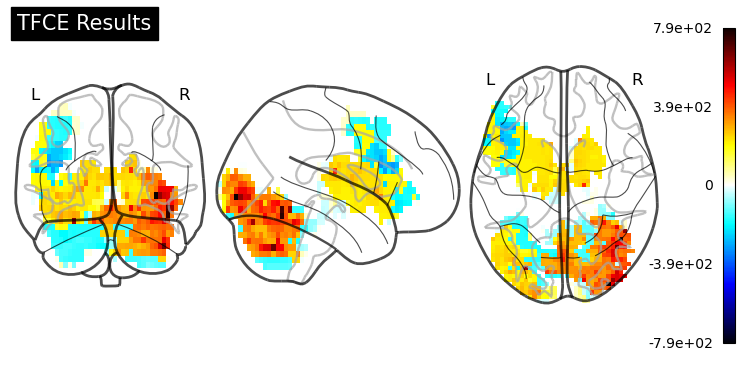

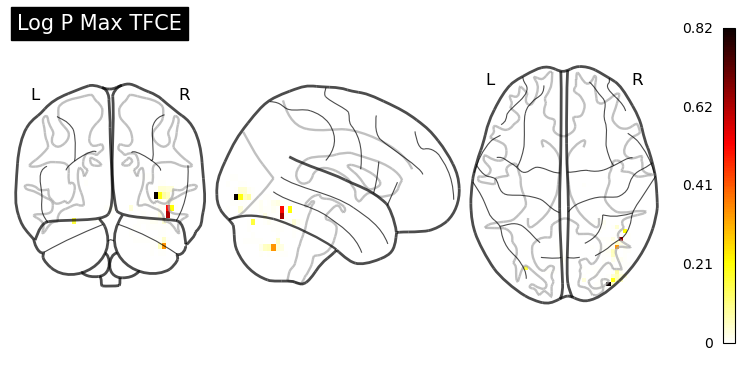

In [126]:
threshold = 0  # 5% corrected

result_img = out_dict_selfvfix_mask['tfce']

# Plotting the TFCE map
plotting.plot_glass_brain(result_img, threshold=0.001, title='TFCE Results', display_mode='ortho',plot_abs=False,
                       colorbar=True)

plt.show()


# logp: Negative log10 p-values associated with the significance test of the n_regressors explanatory variates against 
#the n_descriptors target variates. Family-wise corrected p-values, based on h0_max_tfce.

logp_max_tfce_img = out_dict_selfvfix_mask['logp_max_tfce']

# Plotting the logp_max_tfce map
plotting.plot_glass_brain(logp_max_tfce_img, threshold=threshold, title='Log P Max TFCE', display_mode='ortho',plot_abs=False,
                        colorbar=True)

# Display the plot
plt.show()

n_detections = (out_dict_selfvfix_mask['logp_max_tfce'].get_fdata() > threshold).sum()
new_title = f"{n_detections} sig. voxels"

# # Load your TFCE result NIfTI file (replace 'result_file.nii.gz' with your actual file path)
# result_img = out_dict_selfvfix_mask['logp_max_size']

# # Plotting the TFCE map
# plotting.plot_glass_brain(result_img, threshold=0.001, title='logp max size', display_mode='ortho',plot_abs=False,
#                        colorbar=True)

# plt.show()

# logp_max_tfce_img = out_dict_selfvfix_mask['logp_max_mass']

# # Plotting the logp_max_tfce map
# plotting.plot_glass_brain(logp_max_tfce_img, threshold=0, title='logp max mass', display_mode='ortho',plot_abs=False,
#                         colorbar=True)

# # Display the plot
# plt.show()

# logp_max_tfce_img = out_dict_selfvfix_mask['logp_max_t']

# # Plotting the logp_max_tfce map
# plotting.plot_glass_brain(logp_max_tfce_img, threshold=0, title='logp max t', display_mode='ortho',plot_abs=False,
#                         colorbar=True)

# # Display the plot
# plt.show()

In [67]:
n_detections = (out_dict_selfvfix_mask['logp_max_tfce'].get_fdata() > threshold).sum()
n_detections

5

### Aim2A work 

In [220]:
perc_symptom_change = [
0.41,
0.5,
0.5625,
0.4931506849,
0.375,
0.5714285714,
0.7313432836,
0.3908045977,
0.375,
0.7162162162,
0.3928571429,
0.3770491803,
0.6571428571,
0.3333333333,
0.3333333333,
0.6021505376,
0.7804878049,
0.3663366337,
0.4554455446,
0.2592592593,
0.7321428571,
0.4305555556,
0.4642857143,
0.4333333333,
0.1851851852,
0.3,
0.2916666667]

sex = [0,
0,
0,
0,
1,
1,
0,
0,
0,
0,
0,
1,
0,
0,
0,
0,
1,
0,
0,
1,
0,
0,
0,
0,
0,
0,
1]

age = [22,
25,
25,
28,
34,
23,
27,
27,
23,
28,
22,
30,
23,
26,
24,
38,
28,
24,
28,
19,
23,
25,
24,
23,
22,
26,
25]

subject_label = ['103',
'107',
'109',
'110',
'111',
'113',
'114',
'115',
'117',
'118',
'119',
'120',
'122',
'123',
'125',
'126',
'127',
'128',
'129',
'132',
'136',
'139',
'140',
'143',
'144',
'147',
'150']

intercept = np.ones(len(age))
intercept = np.expand_dims(intercept, axis = -1)

In [221]:
perc_symptom_change = np.array(np.round(perc_symptom_change,3))
perc_symptom_change = np.expand_dims(perc_symptom_change, axis = -1)
age = np.array(age)
age = np.expand_dims(age, axis = -1)
sex = np.array(sex)
sex = np.expand_dims(sex, axis = -1)
subject_label = np.array(subject_label)
subject_label= np.expand_dims(subject_label, axis=-1)

In [222]:
# Separate sessions and create sets for quick lookup
second_level_input = file_lists['self-other']
ses01_patients = {entry for entry in file_lists['self-other'] if entry.startswith('/Volumes/Seagate Desktop Drive/kdata/results/first_level_results/sub1') and entry.endswith('ses01.nii.gz')}
ses01_patient_indices = [i for i, entry in enumerate(file_lists['self-other']) if entry.startswith('/Volumes/Seagate Desktop Drive/kdata/results/first_level_results/sub1') and entry.endswith('ses01.nii.gz')]
ses01_patient_data = ([second_level_input[i] for i in ses01_patient_indices])

ses02_patients = {entry for entry in file_lists['self-other'] if entry.startswith('/Volumes/Seagate Desktop Drive/kdata/results/first_level_results/sub1') and entry.endswith('ses02.nii.gz')}
ses02_patient_indices = [i for i, entry in enumerate(file_lists['self-other']) if entry.startswith('/Volumes/Seagate Desktop Drive/kdata/results/first_level_results/sub1') and entry.endswith('ses02.nii.gz')]
ses02_patient_data = ([second_level_input[i] for i in ses02_patient_indices])

ses01_controls = {entry for entry in file_lists['self-other'] if entry.startswith('/Volumes/Seagate Desktop Drive/kdata/results/first_level_results/sub2') and entry.endswith('ses01.nii.gz')}
ses01_controls_indices = [i for i, entry in enumerate(file_lists['self-other']) if entry.startswith('/Volumes/Seagate Desktop Drive/kdata/results/first_level_results/sub2') and entry.endswith('ses01.nii.gz')]
ses01_controls_data = ([second_level_input[i] for i in ses01_controls_indices])

ses02_controls = {entry for entry in file_lists['self-other'] if entry.startswith('/Volumes/Seagate Desktop Drive/kdata/results/first_level_results/sub2') and entry.endswith('ses02.nii.gz')}
ses02_controls_indices = [i for i, entry in enumerate(file_lists['self-other']) if entry.startswith('/Volumes/Seagate Desktop Drive/kdata/results/first_level_results/sub2') and entry.endswith('ses02.nii.gz')]
ses02_controls_data = ([second_level_input[i] for i in ses02_controls_indices])

controls_prevpost = np.concatenate((ses01_controls_data,ses02_controls_data))
patients_prevpost = np.concatenate((ses01_patient_data,ses02_patient_data))
pre = np.concatenate((ses01_patient_data,ses01_controls_data))
ses01_patient_data1 = ses01_patient_data 
len(ses01_patient_data1)

30

In [223]:
ses01_patient_data_rv=ses01_patient_data1
del(ses01_patient_data_rv[0])  #- 102
del(ses01_patient_data_rv[21])  #- 138
del(ses01_patient_data_rv[25])  #- 145

### Aim2a-v2 

In [78]:
# aim2av2_sldm = np.hstack((intercept,perc_symptom_change,age,sex))
aim2av2_sldm = np.hstack((intercept,perc_symptom_change))

# aim2av2_sldm = pd.DataFrame(aim2av2_sldm, columns=['intercept','perc_symptom_change','age','sex'])
aim2av2_sldm = pd.DataFrame(aim2av2_sldm, columns=['intercept','perc_symptom_change'])

aim2av2_sldm.shape

(27, 2)

In [79]:
aim2av2_sldm

,intercept,perc_symptom_change
0,1.0,0.410
1,1.0,0.500
2,1.0,0.562
3,1.0,0.493
4,1.0,0.375
5,1.0,0.571
6,1.0,0.731
7,1.0,0.391
8,1.0,0.375
9,1.0,0.716


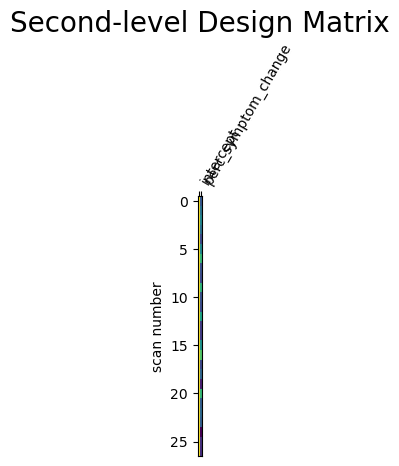

In [289]:
from nilearn.glm.second_level import SecondLevelModel 
second_level_input = ses01_patient_data_rv
second_level_input

second_level_model = SecondLevelModel()
plotting.plot_design_matrix(aim2av2_sldm, rescale=False)
plt.title("Second-level Design Matrix", fontsize=20)
plotting.show()

from nilearn.glm.second_level import SecondLevelModel

second_level_model = SecondLevelModel(n_jobs=2).fit(second_level_input, design_matrix=aim2av2_sldm)

In [290]:
#Making contrasts! 
contrast_matrix = np.eye(aim2av2_sldm.shape[1])
basic_contrasts = {
    column: contrast_matrix[i]
    for i, column in enumerate(aim2av2_sldm.columns)
    }

contrasts = {
     "intercept": (basic_contrasts['intercept'])
    }      
contrasts


{'intercept': array([1., 0.])}

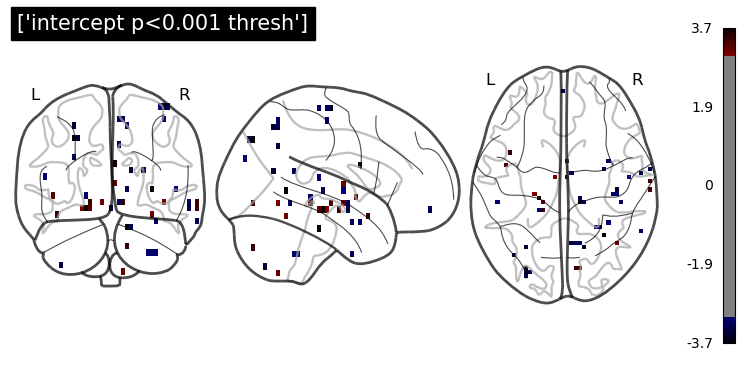

In [292]:
 # Iterate on contrasts
for contrast_id, contrast_val in contrasts.items():
    outputs = second_level_model.compute_contrast(contrast_val, output_type='all')

    plotting.plot_glass_brain(
        outputs['z_score'],
        threshold=p001_unc,
        display_mode="ortho",
        title=[contrast_id+" p<0.001 thresh"],
        plot_abs=False,
        colorbar=True
        )
    plotting.show()

In [293]:
contrast_val = contrast_val.tolist()
contrast_val

[1.0, 0.0]

In [285]:
#TFCE - non-parametric cluster correction

from nilearn.glm.second_level import non_parametric_inference

out_dict = non_parametric_inference(
    second_level_input,
    design_matrix=aim2av2_sldm,
    second_level_contrast=contrast_val,
    n_perm=10000,  # 500 for the sake of time. Ideally, this should be 10,000.
    two_sided_test=True,
    smoothing_fwhm=8.0,
    tfce=True,
    #mask=dmn_avg_mask,
    threshold=0.001,
)

/Users/angelafang/opt/anaconda3/envs/nilearn/lib/python3.9/site-packages/nilearn/mass_univariate/permuted_least_squares.py:994: UserWarning: Data array used to create a new image contains 64-bit ints. This is likely due to creating the array with numpy and passing `int` as the `dtype`. Many tools such as FSL and SPM cannot deal with int64 in Nifti images, so for compatibility the data has been converted to int32.
  image.new_img_like(masker.mask_img_, metric_map),
/Users/angelafang/opt/anaconda3/envs/nilearn/lib/python3.9/site-packages/nilearn/masking.py:974: UserWarning: Data array used to create a new image contains 64-bit ints. This is likely due to creating the array with numpy and passing `int` as the `dtype`. Many tools such as FSL and SPM cannot deal with int64 in Nifti images, so for compatibility the data has been converted to int32.
  return new_img_like(mask_img, unmasked, affine)


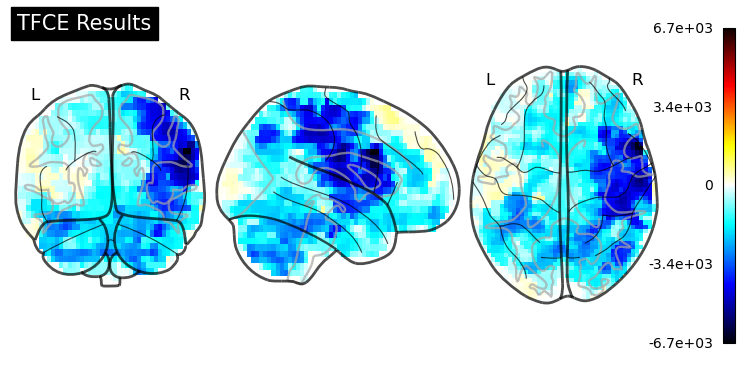

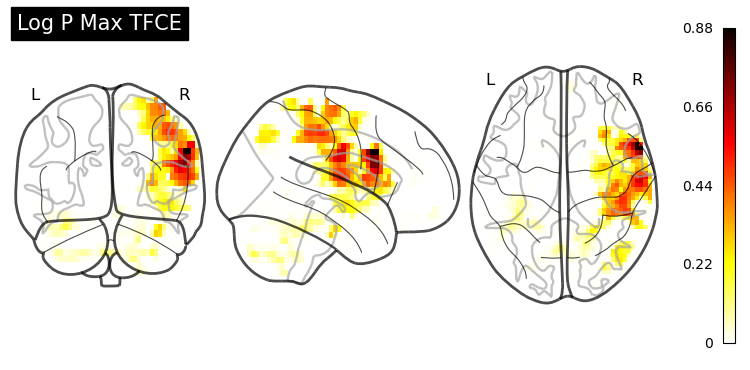

In [287]:
# Load your TFCE result NIfTI file (replace 'result_file.nii.gz' with your actual file path)
result_img = out_dict['tfce']

# Plotting the TFCE map
plotting.plot_glass_brain(result_img, threshold=0.001, title='TFCE Results', display_mode='ortho',plot_abs=False,
                       colorbar=True)

plt.show()

logp_max_tfce_img = out_dict['logp_max_tfce']

threshold = -np.log10(0.1)  # 10% corrected
threshold = 0
# Plotting the logp_max_tfce map
plotting.plot_glass_brain(logp_max_tfce_img, threshold=threshold, title='Log P Max TFCE', display_mode='ortho',plot_abs=False,
                        colorbar=True)

# Display the plot
plt.show()

In [294]:
#TFCE - non-parametric cluster correction

from nilearn.glm.second_level import non_parametric_inference

out_dict_no_covars = non_parametric_inference(
    second_level_input,
    design_matrix=aim2av2_sldm,
    second_level_contrast=contrast_val,
    n_perm=10000,  # 500 for the sake of time. Ideally, this should be 10,000.
    two_sided_test=True,
    smoothing_fwhm=8.0,
    tfce=True,
    #mask=dmn_avg_mask,
    threshold=0.001,
)

/Users/angelafang/opt/anaconda3/envs/nilearn/lib/python3.9/site-packages/nilearn/mass_univariate/permuted_least_squares.py:994: UserWarning: Data array used to create a new image contains 64-bit ints. This is likely due to creating the array with numpy and passing `int` as the `dtype`. Many tools such as FSL and SPM cannot deal with int64 in Nifti images, so for compatibility the data has been converted to int32.
  image.new_img_like(masker.mask_img_, metric_map),
/Users/angelafang/opt/anaconda3/envs/nilearn/lib/python3.9/site-packages/nilearn/masking.py:974: UserWarning: Data array used to create a new image contains 64-bit ints. This is likely due to creating the array with numpy and passing `int` as the `dtype`. Many tools such as FSL and SPM cannot deal with int64 in Nifti images, so for compatibility the data has been converted to int32.
  return new_img_like(mask_img, unmasked, affine)


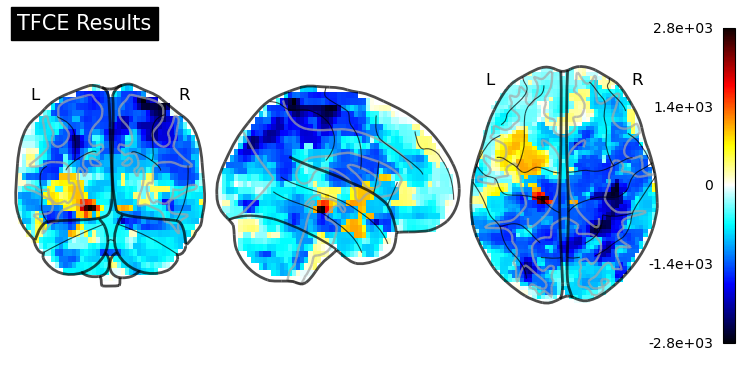

/Users/angelafang/opt/anaconda3/envs/nilearn/lib/python3.9/site-packages/nilearn/plotting/displays/_slicers.py:438: UserWarning: empty mask
  xmin_, xmax_, ymin_, ymax_, zmin_, zmax_ = get_mask_bounds(


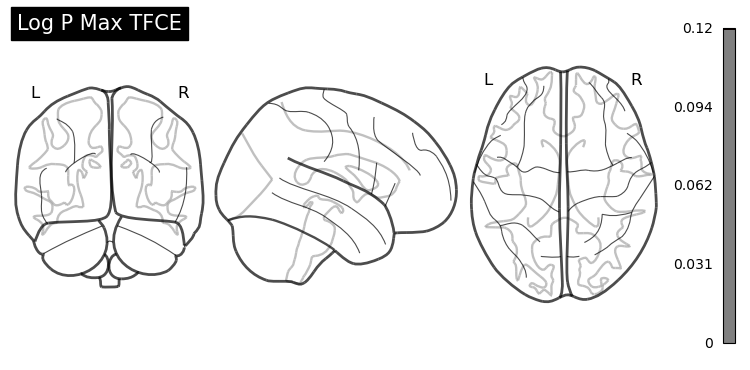

In [296]:
# Load your TFCE result NIfTI file (replace 'result_file.nii.gz' with your actual file path)
result_img = out_dict_no_covars['tfce']

# Plotting the TFCE map
plotting.plot_glass_brain(result_img, threshold=0.001, title='TFCE Results', display_mode='ortho',plot_abs=False,
                       colorbar=True)

plt.show()

logp_max_tfce_img = out_dict_no_covars['logp_max_tfce']

threshold = -np.log10(0.1)  # 10% corrected
# Plotting the logp_max_tfce map
plotting.plot_glass_brain(logp_max_tfce_img, threshold=threshold, title='Log P Max TFCE', display_mode='ortho',plot_abs=False,
                        colorbar=True)

# Display the plot
plt.show()

### aim 2A -- self-other correlates predict % symptom change (version 1) 

In [416]:
# self-other all subs correlate (mPFC): 

coords = [(0.090004, 34.556005, 27.00000)]
labels = [
    "cluster1"
]

coords_subregions = [(-3.112996, 31.353005, 52.00000),(6.496004,12.135005,67.000000),(-9.518996,8.932005,67.000000)]
labels_subregions = [
    "cluster1a",
    "cluster1b",
    "cluster1c"
]


# creating template images for plotting / first-level masks 
from nilearn import plotting, masking
from nilearn.masking import _unmask_3d
from nilearn.maskers import nifti_spheres_masker
import nibabel as nib
from nibabel import Nifti1Image
from nilearn.image import resample_to_img 

sess = '01'
sub = '102'
fmri_imgs = layout.get(subject=sub,
            datatype='func', task='selfother',session = sess,
            desc='preproc',
            space='MNI152NLin2009cAsym',
            extension='nii.gz',
           return_type='file')

space_defining_image = masking.compute_brain_mask(fmri_imgs[0])

_, A = nifti_spheres_masker._apply_mask_and_get_affinity(
    seeds=coords,
    niimg=None,
    radius=10,
    allow_overlap=True, 
    mask_img=space_defining_image)

A = A.sum(axis=0)
A = np.array(A).flatten()

sphere_mask = _unmask_3d(A,mask=space_defining_image.get_fdata().astype(bool))
sphere_mask = Nifti1Image(sphere_mask, space_defining_image.affine)


# can use masker to create 1 value per sphere 
from nilearn.maskers import NiftiSpheresMasker

masker = NiftiSpheresMasker(
    coords,
    radius=15,
    t_r=2.5,
    mask_img=space_defining_image
)

In [417]:
# subjects missing ses02:
# 102, 138, 145, 209, 221, 237 
subjects = layout.get_subjects()
subjects2 = []
subjects2 = subjects
#subjects2 = subjects
#testing second level (removing all subs with errors) 
del(subjects2[0]) #- 102 
del(subjects2[21]) #- 138 +1
del(subjects2[25]) #- 145 +1 
del(subjects2[32]) #- 209 +1 
del(subjects2[40]) #- 221 +1 
del(subjects2[50]) #- 237 +2 

subjects = layout.get_subjects()

In [226]:
# Average activity within masker region 

from scipy.stats import norm

p001_unc = norm.isf(0.001)
selfother_correlates = []
selfother_correlates = {"self-other": list()
    }

sub_order = {"self-other": list()
    }

nosessions = ['01']

for sess in nosessions: 

    if sess == '01':
        subject_list = subjects2 #CHANGE FROM NORMAL FIRST LEVEL -- ONLY TAKING SUBS WITH BOTH SES01 AND SES02 
    elif sess == '02':
        subject_list = subjects2
    
    for sub in subject_list: 
# change lines below -- can change to "mask", change task to "self-other" -- should match the same format as in the load_bids_events function
        fmri_imgs = layout.get(subject=sub,
                    datatype='func', task='selfother',session = sess,
                    desc='preproc',
                    space='MNI152NLin2009cAsym',
                    extension='nii.gz',
                   return_type='file')
        hrf_model = "spm" #canonical hrf 
        high_pass = 0.01 # The cutoff for the drift model is 0.01 Hz.

        dmn_time_series = []
        for con_img in fmri_imgs:
            dmn_time_series.append(masker.fit_transform(con_img))
        dmn_time_series = np.concatenate(dmn_time_series, axis = 0)

        confound_files = layout.get(subject=sub,
                        datatype='func', task='selfother',session = sess,
                        desc='confounds',
                       extension="tsv",
                       return_type='file')

# Select confounds -- set right now to just the 6 motion parameters but can add in more/less! 
       #32 confound_vars -- TOOK OUT GLOBAL SIGNAL 
        confound_vars = ['trans_x','trans_x_derivative1','trans_x_derivative1_power2','trans_x_power2',
                           'trans_y','trans_y_derivative1','trans_y_derivative1_power2','trans_y_power2',
                             'trans_z','trans_z_derivative1','trans_z_derivative1_power2','trans_z_power2',
                             'rot_x','rot_x_derivative1','rot_x_derivative1_power2','rot_x_power2',
                             'rot_y','rot_y_derivative1','rot_y_derivative1_power2','rot_y_power2',
                             'rot_z','rot_z_derivative1','rot_z_derivative1_power2','rot_z_power2',
                             'csf','csf_derivative1','csf_derivative1_power2','csf_power2',
                             'white_matter','white_matter_derivative1','white_matter_derivative1_power2','white_matter_power2'
                            ]
        #6 confound vars
        #confound_vars = ['trans_x','trans_y','trans_z',
         #        'rot_x','rot_y','rot_z']
        final_confounds = confound_vars

        design_matrices = []

        for idx, img in enumerate(fmri_imgs):
# Build experimental paradigm
            run = idx
            events,tr,n_scans = load_bids_events(layout,layout_raw, sub, run, sess)
    # Define the sampling times for the design matrix
            frame_times = np.arange(n_scans) * tr
            confound_file = confound_files[run]
            confound_df = pd.read_csv(confound_file, delimiter='\t')
            confound_df = confound_df[final_confounds]
            confound_df.fillna(0, inplace=True)
    # Build design matrix with the previously defined parameters
            design_matrix = make_first_level_design_matrix(
                frame_times,
                events,
                hrf_model=hrf_model,
                drift_model="polynomial",
                drift_order=3,
                add_regs=confound_df,
                add_reg_names=confound_vars,
                high_pass=high_pass,
            )
            design_matrix = design_matrix.iloc[:,0:11] # taking out constant intercept and adding in an intercept for each individual run
# this allows average voxel to vary across runs instead of assuming its constant 
            if idx == 0:
                design_matrix['intercept1'] = 1 
                design_matrix['intercept2'] = 0
                design_matrix['intercept3'] = 0
            elif idx == 1:
                design_matrix['intercept1'] = 0
                design_matrix['intercept2'] = 1 
                design_matrix['intercept3'] = 0
            else: 
                design_matrix['intercept1'] = 0
                design_matrix['intercept2'] = 0 
                design_matrix['intercept3'] = 1
    # put the design matrices in a list
            design_matrices.append(design_matrix)
            design_matrix_allruns = []    
            design_matrix_allruns = np.concatenate(design_matrices, axis = 0)    
# can visualize the design matrix with the line below 
#plot_design_matrix(design_matrices[1])
        contrast_matrix = np.eye(design_matrix.shape[1])
        basic_contrasts = {
            column: contrast_matrix[i]
            for i, column in enumerate(design_matrix.columns)
        }

        contrasts = {
            "self-other": (basic_contrasts["self"] - basic_contrasts["other"]),

        }
        #added gm mask 
        #fmri_glm = FirstLevelModel()
        labels, estimates = run_glm(dmn_time_series, design_matrix_allruns)
        
        for index, (contrast_id, contrast_val) in enumerate(contrasts.items()):
        
        # compute contrast-related statistics
            contrast = compute_contrast(labels, estimates, contrast_val)

            selfother_correlates[contrast_id].append(contrast)
            sub_order[contrast_id].append('sub'+ sub + '-ses' + sess)            
            z_score = contrast.z_score()
            print(f"{contrast_id}: Z-score outputs: {z_score}") 
        print("Subject = " + sub + " Completed!")
          

self-other: Z-score outputs: [1.25984882]
Subject = 103 Completed!
self-other: Z-score outputs: [1.70021088]
Subject = 107 Completed!
self-other: Z-score outputs: [4.47916546]
Subject = 109 Completed!
self-other: Z-score outputs: [5.06046373]
Subject = 110 Completed!
self-other: Z-score outputs: [2.33771046]
Subject = 111 Completed!
self-other: Z-score outputs: [0.98601894]
Subject = 113 Completed!
self-other: Z-score outputs: [5.38084306]
Subject = 114 Completed!
self-other: Z-score outputs: [3.72870941]
Subject = 115 Completed!
self-other: Z-score outputs: [2.12188848]
Subject = 117 Completed!
self-other: Z-score outputs: [1.8838816]
Subject = 118 Completed!
self-other: Z-score outputs: [1.91980422]
Subject = 119 Completed!
self-other: Z-score outputs: [1.94862653]
Subject = 120 Completed!
self-other: Z-score outputs: [3.61646988]
Subject = 122 Completed!
self-other: Z-score outputs: [1.31324167]
Subject = 123 Completed!
self-other: Z-score outputs: [2.85455721]
Subject = 125 Complet

In [418]:
second_level_input = []
for i in selfother_correlates['self-other']:
    second_level_input.append(i.effect_size())

second_level_input = np.concatenate(second_level_input,axis=0)  

def check_subject_id(subject_id, group):
    if group == 1:
        return subject_id.startswith('sub1')
    elif group == 2:
        return subject_id.startswith('sub2')
    else:
        return False
        
# Find indices for subjects in group 1 (100s) and group 2 (200s) for ses01 and ses02
patients_ses01_indices = [i for i, sub in enumerate(sub_order['self-other']) if check_subject_id(sub, 1) and sub.endswith('-ses01')]
# controls_ses01_indices = [i for i, sub in enumerate(sub_order['self-other']) if check_subject_id(sub, 2) and sub.endswith('-ses01')]
# patients_ses02_indices = [i for i, sub in enumerate(sub_order['self-other']) if check_subject_id(sub, 1) and sub.endswith('-ses02')]
# controls_ses02_indices = [i for i, sub in enumerate(sub_order['self-other']) if check_subject_id(sub, 2) and sub.endswith('-ses02')]

# # Extract z-scores for ses01 and ses02
z_scores_patients_ses01 = second_level_input[patients_ses01_indices]
# z_scores_patients_ses02 = second_level_input[patients_ses02_indices, :]
# z_scores_controls_ses01 = second_level_input[controls_ses01_indices, :]
# z_scores_controls_ses02 = second_level_input[controls_ses02_indices, :]


In [419]:
ses01_patient_data = z_scores_patients_ses01
ses01_patient_data

array([[ 1.45292778],
       [ 2.06294847],
       [ 3.57827619],
       [ 4.98137505],
       [ 1.96167121],
       [ 1.82897667],
       [ 3.86579446],
       [ 3.39729168],
       [ 1.75977539],
       [ 1.8010585 ],
       [ 2.71589262],
       [ 1.87160913],
       [ 3.00674069],
       [ 2.06304625],
       [ 1.40496368],
       [ 0.55993712],
       [ 2.13620784],
       [-0.1323185 ],
       [ 2.62473384],
       [ 0.04125662],
       [ 2.52138116],
       [ 1.28892666],
       [ 1.93141317],
       [-0.61578344],
       [ 1.46025265],
       [ 0.74723116],
       [ 0.11693327]])

In [420]:
col_label = ['selfothercorr']
patient_data = pd.DataFrame(ses01_patient_data, columns=col_label)
patient_data['perc_symptom_change'] = perc_symptom_change


In [421]:
patient_data

,selfothercorr,perc_symptom_change
0,1.452928,0.410
1,2.062948,0.500
2,3.578276,0.562
3,4.981375,0.493
4,1.961671,0.375
5,1.828977,0.571
6,3.865794,0.731
7,3.397292,0.391
8,1.759775,0.375
9,1.801058,0.716


In [442]:
import statsmodels.api as sm

X = patient_data[col_label]
X = sm.add_constant(X)

# Define the dependent variable
y = patient_data['perc_symptom_change']

# Fit the model
selfother_prediction_model = sm.OLS(y, X).fit()

# Print the summary of the regression
print(selfother_prediction_model.summary())

                             OLS Regression Results                            
Dep. Variable:     perc_symptom_change   R-squared:                       0.180
Model:                             OLS   Adj. R-squared:                  0.147
Method:                  Least Squares   F-statistic:                     5.478
Date:                 Fri, 02 Aug 2024   Prob (F-statistic):             0.0275
Time:                         14:42:42   Log-Likelihood:                 14.776
No. Observations:                   27   AIC:                            -25.55
Df Residuals:                       25   BIC:                            -22.96
Df Model:                            1                                         
Covariance Type:             nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.3661      0.050 

In [449]:
X = ses01_patient_data
X

array([[ 1.45292778],
       [ 2.06294847],
       [ 3.57827619],
       [ 4.98137505],
       [ 1.96167121],
       [ 1.82897667],
       [ 3.86579446],
       [ 3.39729168],
       [ 1.75977539],
       [ 1.8010585 ],
       [ 2.71589262],
       [ 1.87160913],
       [ 3.00674069],
       [ 2.06304625],
       [ 1.40496368],
       [ 0.55993712],
       [ 2.13620784],
       [-0.1323185 ],
       [ 2.62473384],
       [ 0.04125662],
       [ 2.52138116],
       [ 1.28892666],
       [ 1.93141317],
       [-0.61578344],
       [ 1.46025265],
       [ 0.74723116],
       [ 0.11693327]])

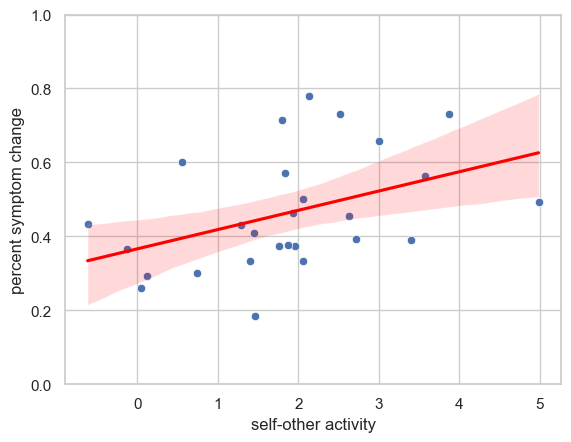

In [440]:
import seaborn as sns

# Plot using Seaborn
sns.set(style='whitegrid')  # Set style
X = ses01_patient_data
# Define the dependent variable
y = patient_data['perc_symptom_change']
# Create a scatter plot of the data
sns.scatterplot(x=X[:,0], y=y)

# Plot the regression line using seaborn's regplot
sns.regplot(x=X[:,0], y=y, scatter=False, color='red', label='OLS Regression Line', ci=95)

# Customize plot
plt.xlabel('self-other activity')
plt.ylabel('percent symptom change')
# plt.title('OLS Regression with Seaborn')
# plt.legend()
plt.ylim(0, 1)  # Set y-axis limits

plt.savefig('neuralcorr_symptomchange_regression.png', dpi=300, bbox_inches='tight')


# Show plot
plt.show()

In [443]:
# Initialize the linear regression model
model = LinearRegression()

mse_scorer = make_scorer(mean_squared_error, greater_is_better=False)


# Leave-One-Out Cross-Validation
loo = LeaveOneOut()
loo_scores = cross_val_score(model, X, y, cv=loo, scoring=mse_scorer)
loo_mean_score = np.mean(loo_scores)
print(f'Leave-One-Out Cross-Validation Mean Score: {loo_mean_score:.4f}')

# 10-Fold Cross-Validation
kf = KFold(n_splits=10, shuffle=True, random_state=42)
kf_scores = cross_val_score(model, X, y, cv=kf, scoring=mse_scorer)
kf_mean_score = np.mean(kf_scores)
print(f'10-Fold Cross-Validation Mean Score (MSE): {-kf_mean_score:.4f}')

Leave-One-Out Cross-Validation Mean Score: -0.0226
10-Fold Cross-Validation Mean Score (MSE): 0.0231


In [446]:
### treating regression as logistic (all patients => 0.3 symptom reduction =1)
from sklearn.linear_model import LogisticRegression
from sklearn.datasets import make_classification

y_binary = np.where(y >= 0.3, 1, 0)

# Initialize the logistic regression model
model = LogisticRegression()

# Leave-One-Out Cross-Validation
loo = LeaveOneOut()
loo_scores = cross_val_score(model, X, y_binary, cv=loo, scoring='accuracy')
loo_mean_score = np.mean(loo_scores)
print(f'Leave-One-Out Cross-Validation Mean Score (Accuracy): {loo_mean_score:.4f}')

# 10-Fold Cross-Validation
kf = KFold(n_splits=10, shuffle=True, random_state=42)
kf_scores = cross_val_score(model, X, y_binary, cv=kf, scoring='accuracy')
kf_mean_score = np.mean(kf_scores)
print(f'10-Fold Cross-Validation Mean Score (Accuracy): {kf_mean_score:.4f}')

Leave-One-Out Cross-Validation Mean Score (Accuracy): 0.8519
10-Fold Cross-Validation Mean Score (Accuracy): 0.8833


In [ ]:
#### redoing w subregions

In [86]:
# self-other all subs correlate (mPFC): 

coords = [(0.090004, 34.556005, 27.00000)]
labels = [
    "cluster1"
]

coords_subregions = [(-3.112996, 31.353005, 52.00000),(6.496004,12.135005,67.000000),(-9.518996,8.932005,67.000000)]
labels_subregions = [
    "cluster1a",
    "cluster1b",
    "cluster1c"
]


# creating template images for plotting / first-level masks 
from nilearn import plotting, masking
from nilearn.masking import _unmask_3d
from nilearn.maskers import nifti_spheres_masker
import nibabel as nib
from nibabel import Nifti1Image
from nilearn.image import resample_to_img 

sess = '01'
sub = '102'
fmri_imgs = layout.get(subject=sub,
            datatype='func', task='selfother',session = sess,
            desc='preproc',
            space='MNI152NLin2009cAsym',
            extension='nii.gz',
           return_type='file')

space_defining_image = masking.compute_brain_mask(fmri_imgs[0])

_, A = nifti_spheres_masker._apply_mask_and_get_affinity(
    seeds=coords_subregions,
    niimg=None,
    radius=10,
    allow_overlap=True, 
    mask_img=space_defining_image)

A = A.sum(axis=0)
A = np.array(A).flatten()

sphere_mask = _unmask_3d(A,mask=space_defining_image.get_fdata().astype(bool))
sphere_mask = Nifti1Image(sphere_mask, space_defining_image.affine)


# can use masker to create 1 value per sphere 
from nilearn.maskers import NiftiSpheresMasker

masker = NiftiSpheresMasker(
    coords_subregions,
    radius=8,
    t_r=2.5,
    mask_img=space_defining_image
)

In [89]:
# Average activity within masker region 

from scipy.stats import norm

p001_unc = norm.isf(0.001)

selfother_correlates = {"self-other": list()
    }

sub_order = {"self-other": list()
    }

nosessions = ['01']

for sess in nosessions: 

    if sess == '01':
        subject_list = subjects2 #CHANGE FROM NORMAL FIRST LEVEL -- ONLY TAKING SUBS WITH BOTH SES01 AND SES02 
    elif sess == '02':
        subject_list = subjects2
    
    for sub in subject_list: 
# change lines below -- can change to "mask", change task to "self-other" -- should match the same format as in the load_bids_events function
        fmri_imgs = layout.get(subject=sub,
                    datatype='func', task='selfother',session = sess,
                    desc='preproc',
                    space='MNI152NLin2009cAsym',
                    extension='nii.gz',
                   return_type='file')
        hrf_model = "spm" #canonical hrf 
        high_pass = 0.01 # The cutoff for the drift model is 0.01 Hz.

        dmn_time_series = []
        for con_img in fmri_imgs:
            dmn_time_series.append(masker.fit_transform(con_img))
        dmn_time_series = np.concatenate(dmn_time_series, axis = 0)

        confound_files = layout.get(subject=sub,
                        datatype='func', task='selfother',session = sess,
                        desc='confounds',
                       extension="tsv",
                       return_type='file')

# Select confounds -- set right now to just the 6 motion parameters but can add in more/less! 
       #32 confound_vars -- TOOK OUT GLOBAL SIGNAL 
        confound_vars = ['trans_x','trans_x_derivative1','trans_x_derivative1_power2','trans_x_power2',
                           'trans_y','trans_y_derivative1','trans_y_derivative1_power2','trans_y_power2',
                             'trans_z','trans_z_derivative1','trans_z_derivative1_power2','trans_z_power2',
                             'rot_x','rot_x_derivative1','rot_x_derivative1_power2','rot_x_power2',
                             'rot_y','rot_y_derivative1','rot_y_derivative1_power2','rot_y_power2',
                             'rot_z','rot_z_derivative1','rot_z_derivative1_power2','rot_z_power2',
                             'csf','csf_derivative1','csf_derivative1_power2','csf_power2',
                             'white_matter','white_matter_derivative1','white_matter_derivative1_power2','white_matter_power2'
                            ]
        #6 confound vars
        #confound_vars = ['trans_x','trans_y','trans_z',
         #        'rot_x','rot_y','rot_z']
        final_confounds = confound_vars

        design_matrices = []

        for idx, img in enumerate(fmri_imgs):
# Build experimental paradigm
            run = idx
            events,tr,n_scans = load_bids_events(layout,layout_raw, sub, run, sess)
    # Define the sampling times for the design matrix
            frame_times = np.arange(n_scans) * tr
            confound_file = confound_files[run]
            confound_df = pd.read_csv(confound_file, delimiter='\t')
            confound_df = confound_df[final_confounds]
            confound_df.fillna(0, inplace=True)
    # Build design matrix with the previously defined parameters
            design_matrix = make_first_level_design_matrix(
                frame_times,
                events,
                hrf_model=hrf_model,
                drift_model="polynomial",
                drift_order=3,
                add_regs=confound_df,
                add_reg_names=confound_vars,
                high_pass=high_pass,
            )
            design_matrix = design_matrix.iloc[:,0:11] # taking out constant intercept and adding in an intercept for each individual run
# this allows average voxel to vary across runs instead of assuming its constant 
            if idx == 0:
                design_matrix['intercept1'] = 1 
                design_matrix['intercept2'] = 0
                design_matrix['intercept3'] = 0
            elif idx == 1:
                design_matrix['intercept1'] = 0
                design_matrix['intercept2'] = 1 
                design_matrix['intercept3'] = 0
            else: 
                design_matrix['intercept1'] = 0
                design_matrix['intercept2'] = 0 
                design_matrix['intercept3'] = 1
    # put the design matrices in a list
            design_matrices.append(design_matrix)
            design_matrix_allruns = []    
            design_matrix_allruns = np.concatenate(design_matrices, axis = 0)    
# can visualize the design matrix with the line below 
#plot_design_matrix(design_matrices[1])
        contrast_matrix = np.eye(design_matrix.shape[1])
        basic_contrasts = {
            column: contrast_matrix[i]
            for i, column in enumerate(design_matrix.columns)
        }

        contrasts = {
            "self-other": (basic_contrasts["self"] - basic_contrasts["other"]),

        }
        #added gm mask 
        #fmri_glm = FirstLevelModel()
        labels, estimates = run_glm(dmn_time_series, design_matrix_allruns)
        
        for index, (contrast_id, contrast_val) in enumerate(contrasts.items()):
        
        # compute contrast-related statistics
            contrast = compute_contrast(labels, estimates, contrast_val)

            selfother_correlates[contrast_id].append(contrast)
            sub_order[contrast_id].append('sub'+ sub + '-ses' + sess)            
            z_score = contrast.z_score()
            print(f"{contrast_id}: Z-score outputs: {z_score}") 
        print("Subject = " + sub + " Completed!")
          

self-other: Z-score outputs: [1.07700426 0.42217175 0.71486124]
Subject = 103 Completed!
self-other: Z-score outputs: [-0.96722095 -1.55696336 -2.11432535]
Subject = 107 Completed!
self-other: Z-score outputs: [1.92444673 0.42345241 2.55435817]
Subject = 109 Completed!
self-other: Z-score outputs: [3.3201216  0.24705163 1.63076613]
Subject = 110 Completed!
self-other: Z-score outputs: [0.72579265 2.64946739 2.34985333]
Subject = 111 Completed!
self-other: Z-score outputs: [0.99749347 0.33493026 0.82613872]
Subject = 113 Completed!
self-other: Z-score outputs: [1.3903196  2.62059448 2.83941441]
Subject = 114 Completed!
self-other: Z-score outputs: [0.8420164  0.22270175 3.40210222]
Subject = 115 Completed!
self-other: Z-score outputs: [0.25423371 0.2174094  1.49099567]
Subject = 117 Completed!
self-other: Z-score outputs: [0.44095082 1.60019092 1.46374508]
Subject = 118 Completed!
self-other: Z-score outputs: [0.08943722 0.53884753 0.23263366]
Subject = 119 Completed!
self-other: Z-scor

In [90]:
second_level_input = []
for i in selfother_correlates['self-other']:
    second_level_input.append(i.effect_size())

second_level_input = np.concatenate(second_level_input,axis=0)  

def check_subject_id(subject_id, group):
    if group == 1:
        return subject_id.startswith('sub1')
    elif group == 2:
        return subject_id.startswith('sub2')
    else:
        return False
        
# Find indices for subjects in group 1 (100s) and group 2 (200s) for ses01 and ses02
patients_ses01_indices = [i for i, sub in enumerate(sub_order['self-other']) if check_subject_id(sub, 1) and sub.endswith('-ses01')]
# controls_ses01_indices = [i for i, sub in enumerate(sub_order['self-other']) if check_subject_id(sub, 2) and sub.endswith('-ses01')]
# patients_ses02_indices = [i for i, sub in enumerate(sub_order['self-other']) if check_subject_id(sub, 1) and sub.endswith('-ses02')]
# controls_ses02_indices = [i for i, sub in enumerate(sub_order['self-other']) if check_subject_id(sub, 2) and sub.endswith('-ses02')]

# # Extract z-scores for ses01 and ses02
z_scores_patients_ses01 = second_level_input[patients_ses01_indices, :]
# z_scores_patients_ses02 = second_level_input[patients_ses02_indices, :]
# z_scores_controls_ses01 = second_level_input[controls_ses01_indices, :]
# z_scores_controls_ses02 = second_level_input[controls_ses02_indices, :]


In [91]:
z_scores_patients_ses01

array([[ 1.20838252,  0.33449411,  0.45940889],
       [-0.91227819, -1.13850747, -2.0568282 ],
       [ 2.12858375,  0.41176743,  3.24179801],
       [ 4.55292807,  0.35379802,  1.31579097],
       [ 0.8004449 ,  2.95655786,  2.06547143],
       [ 1.6251986 ,  0.48818927,  1.039627  ],
       [ 0.87000211,  1.59795308,  2.05533099],
       [ 0.7259167 ,  0.17832752,  2.79016389],
       [ 0.19461852,  0.14848403,  1.19772205],
       [ 0.40996618,  1.42784956,  1.36588684],
       [ 0.12400011,  0.76963458,  0.25168401],
       [-1.3592014 ,  0.38599771,  0.29148024],
       [ 2.29143079,  2.06814383,  1.98382589],
       [ 1.12298112, -0.3013309 ,  0.59585264],
       [ 0.50133625, -0.86005155,  0.93819897],
       [ 0.70773559, -0.17887688, -0.10076296],
       [ 2.45599259,  0.75159098,  0.84146209],
       [-0.38461999,  0.64611016,  0.75082558],
       [ 1.79153436,  0.48581097,  1.01674424],
       [ 1.15468927,  1.36719307, -0.11589206],
       [ 0.34884773,  1.86842964,  1.191

In [92]:
ses01_patient_data = z_scores_patients_ses01
ses01_patient_data

array([[ 1.20838252,  0.33449411,  0.45940889],
       [-0.91227819, -1.13850747, -2.0568282 ],
       [ 2.12858375,  0.41176743,  3.24179801],
       [ 4.55292807,  0.35379802,  1.31579097],
       [ 0.8004449 ,  2.95655786,  2.06547143],
       [ 1.6251986 ,  0.48818927,  1.039627  ],
       [ 0.87000211,  1.59795308,  2.05533099],
       [ 0.7259167 ,  0.17832752,  2.79016389],
       [ 0.19461852,  0.14848403,  1.19772205],
       [ 0.40996618,  1.42784956,  1.36588684],
       [ 0.12400011,  0.76963458,  0.25168401],
       [-1.3592014 ,  0.38599771,  0.29148024],
       [ 2.29143079,  2.06814383,  1.98382589],
       [ 1.12298112, -0.3013309 ,  0.59585264],
       [ 0.50133625, -0.86005155,  0.93819897],
       [ 0.70773559, -0.17887688, -0.10076296],
       [ 2.45599259,  0.75159098,  0.84146209],
       [-0.38461999,  0.64611016,  0.75082558],
       [ 1.79153436,  0.48581097,  1.01674424],
       [ 1.15468927,  1.36719307, -0.11589206],
       [ 0.34884773,  1.86842964,  1.191

In [93]:
col_label = ['cluster1a', 'cluster1b', 'cluster1c']
patient_data = pd.DataFrame(ses01_patient_data, columns=col_label)
patient_data['perc_symptom_change'] = perc_symptom_change


In [94]:
import statsmodels.api as sm

X = patient_data[col_label]
X = sm.add_constant(X)

# Define the dependent variable
y = patient_data['perc_symptom_change']

# Fit the model
selfother_prediction_model = sm.OLS(y, X).fit()

# Print the summary of the regression
print(selfother_prediction_model.summary())

                             OLS Regression Results                            
Dep. Variable:     perc_symptom_change   R-squared:                       0.095
Model:                             OLS   Adj. R-squared:                 -0.023
Method:                  Least Squares   F-statistic:                    0.8058
Date:                 Wed, 03 Jul 2024   Prob (F-statistic):              0.504
Time:                         11:54:06   Log-Likelihood:                 13.450
No. Observations:                   27   AIC:                            -18.90
Df Residuals:                       23   BIC:                            -13.72
Df Model:                            3                                         
Covariance Type:             nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.4302      0.040     10.68

In [ ]:
#### redoing w Patients v Controls correlate 

In [127]:
# self-other all subs correlate (mPFC): 

coords = [(48.135005, 42.000000, 1.129640)]
labels = [
    "cluster1"
]


# creating template images for plotting / first-level masks 
from nilearn import plotting, masking
from nilearn.masking import _unmask_3d
from nilearn.maskers import nifti_spheres_masker
import nibabel as nib
from nibabel import Nifti1Image
from nilearn.image import resample_to_img 

sess = '01'
sub = '102'
fmri_imgs = layout.get(subject=sub,
            datatype='func', task='selfother',session = sess,
            desc='preproc',
            space='MNI152NLin2009cAsym',
            extension='nii.gz',
           return_type='file')

space_defining_image = masking.compute_brain_mask(fmri_imgs[0])

_, A = nifti_spheres_masker._apply_mask_and_get_affinity(
    seeds=coords,
    niimg=None,
    radius=10,
    allow_overlap=True, 
    mask_img=space_defining_image)

A = A.sum(axis=0)
A = np.array(A).flatten()

sphere_mask = _unmask_3d(A,mask=space_defining_image.get_fdata().astype(bool))
sphere_mask = Nifti1Image(sphere_mask, space_defining_image.affine)


# can use masker to create 1 value per sphere 
from nilearn.maskers import NiftiSpheresMasker

masker = NiftiSpheresMasker(
    coords,
    radius=8,
    t_r=2.5,
    mask_img=space_defining_image
)

In [128]:
# Average activity within masker region 

from scipy.stats import norm

p001_unc = norm.isf(0.001)

selfother_correlates = {"self-other": list()
    }

sub_order = {"self-other": list()
    }

nosessions = ['01']

for sess in nosessions: 

    if sess == '01':
        subject_list = subjects2 #CHANGE FROM NORMAL FIRST LEVEL -- ONLY TAKING SUBS WITH BOTH SES01 AND SES02 
    elif sess == '02':
        subject_list = subjects2
    
    for sub in subject_list: 
# change lines below -- can change to "mask", change task to "self-other" -- should match the same format as in the load_bids_events function
        fmri_imgs = layout.get(subject=sub,
                    datatype='func', task='selfother',session = sess,
                    desc='preproc',
                    space='MNI152NLin2009cAsym',
                    extension='nii.gz',
                   return_type='file')
        hrf_model = "spm" #canonical hrf 
        high_pass = 0.01 # The cutoff for the drift model is 0.01 Hz.

        dmn_time_series = []
        for con_img in fmri_imgs:
            dmn_time_series.append(masker.fit_transform(con_img))
        dmn_time_series = np.concatenate(dmn_time_series, axis = 0)

        confound_files = layout.get(subject=sub,
                        datatype='func', task='selfother',session = sess,
                        desc='confounds',
                       extension="tsv",
                       return_type='file')

# Select confounds -- set right now to just the 6 motion parameters but can add in more/less! 
       #32 confound_vars -- TOOK OUT GLOBAL SIGNAL 
        confound_vars = ['trans_x','trans_x_derivative1','trans_x_derivative1_power2','trans_x_power2',
                           'trans_y','trans_y_derivative1','trans_y_derivative1_power2','trans_y_power2',
                             'trans_z','trans_z_derivative1','trans_z_derivative1_power2','trans_z_power2',
                             'rot_x','rot_x_derivative1','rot_x_derivative1_power2','rot_x_power2',
                             'rot_y','rot_y_derivative1','rot_y_derivative1_power2','rot_y_power2',
                             'rot_z','rot_z_derivative1','rot_z_derivative1_power2','rot_z_power2',
                             'csf','csf_derivative1','csf_derivative1_power2','csf_power2',
                             'white_matter','white_matter_derivative1','white_matter_derivative1_power2','white_matter_power2'
                            ]
        #6 confound vars
        #confound_vars = ['trans_x','trans_y','trans_z',
         #        'rot_x','rot_y','rot_z']
        final_confounds = confound_vars

        design_matrices = []

        for idx, img in enumerate(fmri_imgs):
# Build experimental paradigm
            run = idx
            events,tr,n_scans = load_bids_events(layout,layout_raw, sub, run, sess)
    # Define the sampling times for the design matrix
            frame_times = np.arange(n_scans) * tr
            confound_file = confound_files[run]
            confound_df = pd.read_csv(confound_file, delimiter='\t')
            confound_df = confound_df[final_confounds]
            confound_df.fillna(0, inplace=True)
    # Build design matrix with the previously defined parameters
            design_matrix = make_first_level_design_matrix(
                frame_times,
                events,
                hrf_model=hrf_model,
                drift_model="polynomial",
                drift_order=3,
                add_regs=confound_df,
                add_reg_names=confound_vars,
                high_pass=high_pass,
            )
            design_matrix = design_matrix.iloc[:,0:11] # taking out constant intercept and adding in an intercept for each individual run
# this allows average voxel to vary across runs instead of assuming its constant 
            if idx == 0:
                design_matrix['intercept1'] = 1 
                design_matrix['intercept2'] = 0
                design_matrix['intercept3'] = 0
            elif idx == 1:
                design_matrix['intercept1'] = 0
                design_matrix['intercept2'] = 1 
                design_matrix['intercept3'] = 0
            else: 
                design_matrix['intercept1'] = 0
                design_matrix['intercept2'] = 0 
                design_matrix['intercept3'] = 1
    # put the design matrices in a list
            design_matrices.append(design_matrix)
            design_matrix_allruns = []    
            design_matrix_allruns = np.concatenate(design_matrices, axis = 0)    
# can visualize the design matrix with the line below 
#plot_design_matrix(design_matrices[1])
        contrast_matrix = np.eye(design_matrix.shape[1])
        basic_contrasts = {
            column: contrast_matrix[i]
            for i, column in enumerate(design_matrix.columns)
        }

        contrasts = {
            "self-other": (basic_contrasts["self"] - basic_contrasts["other"]),

        }
        #added gm mask 
        #fmri_glm = FirstLevelModel()
        labels, estimates = run_glm(dmn_time_series, design_matrix_allruns)
        
        for index, (contrast_id, contrast_val) in enumerate(contrasts.items()):
        
        # compute contrast-related statistics
            contrast = compute_contrast(labels, estimates, contrast_val)

            selfother_correlates[contrast_id].append(contrast)
            sub_order[contrast_id].append('sub'+ sub + '-ses' + sess)            
            z_score = contrast.z_score()
            print(f"{contrast_id}: Z-score outputs: {z_score}") 
        print("Subject = " + sub + " Completed!")
          

self-other: Z-score outputs: [-1.21089411]
Subject = 103 Completed!
self-other: Z-score outputs: [-0.06738755]
Subject = 107 Completed!
self-other: Z-score outputs: [-0.82934415]
Subject = 109 Completed!
self-other: Z-score outputs: [-1.06972036]
Subject = 110 Completed!
self-other: Z-score outputs: [-0.91426726]
Subject = 111 Completed!
self-other: Z-score outputs: [0.654553]
Subject = 113 Completed!
self-other: Z-score outputs: [-0.51040292]
Subject = 114 Completed!
self-other: Z-score outputs: [0.47557223]
Subject = 115 Completed!
self-other: Z-score outputs: [-1.18858221]
Subject = 117 Completed!
self-other: Z-score outputs: [0.27110149]
Subject = 118 Completed!
self-other: Z-score outputs: [-0.80883103]
Subject = 119 Completed!
self-other: Z-score outputs: [0.14130053]
Subject = 120 Completed!
self-other: Z-score outputs: [-0.68804888]
Subject = 122 Completed!
self-other: Z-score outputs: [0.25902443]
Subject = 123 Completed!
self-other: Z-score outputs: [-1.29466304]
Subject = 12

In [129]:
second_level_input = []
for i in selfother_correlates['self-other']:
    second_level_input.append(i.effect_size())

second_level_input = np.concatenate(second_level_input,axis=0)  

def check_subject_id(subject_id, group):
    if group == 1:
        return subject_id.startswith('sub1')
    elif group == 2:
        return subject_id.startswith('sub2')
    else:
        return False
        
# Find indices for subjects in group 1 (100s) and group 2 (200s) for ses01 and ses02
patients_ses01_indices = [i for i, sub in enumerate(sub_order['self-other']) if check_subject_id(sub, 1) and sub.endswith('-ses01')]
# controls_ses01_indices = [i for i, sub in enumerate(sub_order['self-other']) if check_subject_id(sub, 2) and sub.endswith('-ses01')]
# patients_ses02_indices = [i for i, sub in enumerate(sub_order['self-other']) if check_subject_id(sub, 1) and sub.endswith('-ses02')]
# controls_ses02_indices = [i for i, sub in enumerate(sub_order['self-other']) if check_subject_id(sub, 2) and sub.endswith('-ses02')]

# # Extract z-scores for ses01 and ses02
z_scores_patients_ses01 = second_level_input[patients_ses01_indices, :]
# z_scores_patients_ses02 = second_level_input[patients_ses02_indices, :]
# z_scores_controls_ses01 = second_level_input[controls_ses01_indices, :]
# z_scores_controls_ses02 = second_level_input[controls_ses02_indices, :]
z_scores_patients_ses01

ses01_patient_data = z_scores_patients_ses01
ses01_patient_data

array([[-1.46585496],
       [-0.13107527],
       [-1.38241254],
       [-1.62010131],
       [-0.68762741],
       [ 1.97572778],
       [-0.78182673],
       [ 0.65227109],
       [-1.02474325],
       [ 0.29918371],
       [-1.44780535],
       [ 0.2172283 ],
       [-1.15468095],
       [ 0.68529672],
       [-1.34308873],
       [-1.32162377],
       [-0.96570553],
       [ 3.29844341],
       [ 0.07082257],
       [-3.29632113],
       [-0.87525194],
       [ 1.34611555],
       [-0.98945168],
       [-2.14986444],
       [-0.62906208],
       [-0.27477136],
       [-2.00864744]])

In [131]:
col_label = ['cluster1']
patient_data = pd.DataFrame(ses01_patient_data, columns=col_label)
patient_data['perc_symptom_change'] = perc_symptom_change
patient_data

,cluster1,perc_symptom_change
0,-1.465855,0.410
1,-0.131075,0.500
2,-1.382413,0.562
3,-1.620101,0.493
4,-0.687627,0.375
5,1.975728,0.571
6,-0.781827,0.731
7,0.652271,0.391
8,-1.024743,0.375
9,0.299184,0.716


In [132]:
import statsmodels.api as sm

X = patient_data[col_label]
X = sm.add_constant(X)

# Define the dependent variable
y = patient_data['perc_symptom_change']

# Fit the model
selfother_prediction_model = sm.OLS(y, X).fit()

# Print the summary of the regression
print(selfother_prediction_model.summary())

                             OLS Regression Results                            
Dep. Variable:     perc_symptom_change   R-squared:                       0.002
Model:                             OLS   Adj. R-squared:                 -0.038
Method:                  Least Squares   F-statistic:                   0.04426
Date:                 Wed, 03 Jul 2024   Prob (F-statistic):              0.835
Time:                         13:00:28   Log-Likelihood:                 12.125
No. Observations:                   27   AIC:                            -20.25
Df Residuals:                       25   BIC:                            -17.66
Df Model:                            1                                         
Covariance Type:             nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.4663      0.033     13.93

In [412]:
meanRT = [0.10067828,
0.03374875,
-0.0259525,
0.24253978,
0.15091767,
0.25287425,
0.09450669,
0.2738146,
0.07845344,
0.25707115,
0.11022761,
0.02172144,
0.04884375,
0.16361006,
0.24007287,
0.18309302,
0.07035081,
-0.0184576,
0.10743105,
-0.050644,
0.15826234,
0.04237199,
0.09706763,
0.1065445,
0.23411341,
0.09903346,
0.08438024]

meanRT = np.array(np.round(meanRT,3))
meanRT = np.expand_dims(meanRT, axis = -1)

In [413]:
col_label = ["meanRT"]
patient_data = pd.DataFrame(meanRT, columns=col_label)
patient_data['perc_symptom_change'] = perc_symptom_change
patient_data

,meanRT,perc_symptom_change
0,0.101,0.410
1,0.034,0.500
2,-0.026,0.562
3,0.243,0.493
4,0.151,0.375
5,0.253,0.571
6,0.095,0.731
7,0.274,0.391
8,0.078,0.375
9,0.257,0.716


In [414]:
import statsmodels.api as sm

X = patient_data[col_label]
X = sm.add_constant(X)

# Define the dependent variable
y = patient_data['perc_symptom_change']

# Fit the model
RT_prediction_model = sm.OLS(y, X).fit()

# Print the summary of the regression
print(RT_prediction_model.summary())

print(RT_prediction_model.params)

                             OLS Regression Results                            
Dep. Variable:     perc_symptom_change   R-squared:                       0.005
Model:                             OLS   Adj. R-squared:                 -0.035
Method:                  Least Squares   F-statistic:                    0.1179
Date:                 Fri, 02 Aug 2024   Prob (F-statistic):              0.734
Time:                         14:13:27   Log-Likelihood:                 12.165
No. Observations:                   27   AIC:                            -20.33
Df Residuals:                       25   BIC:                            -17.74
Df Model:                            1                                         
Covariance Type:             nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.4497      0.051      8.86

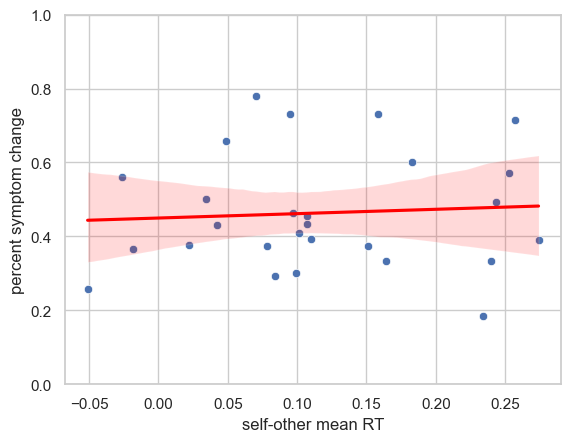

In [415]:
import seaborn as sns

# Plot using Seaborn
sns.set(style='whitegrid')  # Set style
X = meanRT
# Define the dependent variable
y = patient_data['perc_symptom_change']
# Create a scatter plot of the data
sns.scatterplot(x=X[:,0], y=y)

# Plot the regression line using seaborn's regplot
sns.regplot(x=X[:,0], y=y, scatter=False, color='red', label='OLS Regression Line', ci=95)

# Customize plot
plt.xlabel('self-other mean RT')
plt.ylabel('percent symptom change')
# plt.title('OLS Regression with Seaborn')
# plt.legend()
plt.ylim(0, 1)  # Set y-axis limits

plt.savefig('behavioral_symptomchange_regression.png', dpi=300, bbox_inches='tight')
# Show plot
plt.show()

In [ ]:
### leave one out cross-validation (for comparison against neural model)

In [437]:
import numpy as np
from sklearn.model_selection import LeaveOneOut, KFold, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.metrics import make_scorer, mean_squared_error


In [447]:
X = meanRT
y = patient_data['perc_symptom_change']

# Initialize the linear regression model
model = LinearRegression()

mse_scorer = make_scorer(mean_squared_error, greater_is_better=False)


# Leave-One-Out Cross-Validation
loo = LeaveOneOut()
loo_scores = cross_val_score(model, X, y, cv=loo, scoring=mse_scorer)
loo_mean_score = np.mean(loo_scores)
print(f'Leave-One-Out Cross-Validation Mean Score: {loo_mean_score:.4f}')

# 10-Fold Cross-Validation
kf = KFold(n_splits=10, shuffle=True, random_state=42)
kf_scores = cross_val_score(model, X, y, cv=kf, scoring=mse_scorer)
kf_mean_score = np.mean(kf_scores)
print(f'10-Fold Cross-Validation Mean Score (MSE): {-kf_mean_score:.4f}')

#print(f"\nAccuracy using {num_folds}-fold Cross-Validation using all 26 connectivities: {average_accuracy:.2f}")


Leave-One-Out Cross-Validation Mean Score: -0.0279
10-Fold Cross-Validation Mean Score (MSE): 0.0286


In [448]:
### treating regression as logistic (all patients => 0.3 symptom reduction =1)
from sklearn.linear_model import LogisticRegression
from sklearn.datasets import make_classification

y_binary = np.where(y >= 0.3, 1, 0)

# Initialize the logistic regression model
model = LogisticRegression()

# Leave-One-Out Cross-Validation
loo = LeaveOneOut()
loo_scores = cross_val_score(model, X, y_binary, cv=loo, scoring='accuracy')
loo_mean_score = np.mean(loo_scores)
print(f'Leave-One-Out Cross-Validation Mean Score (Accuracy): {loo_mean_score:.4f}')

# 10-Fold Cross-Validation
kf = KFold(n_splits=10, shuffle=True, random_state=42)
kf_scores = cross_val_score(model, X, y_binary, cv=kf, scoring='accuracy')
kf_mean_score = np.mean(kf_scores)
print(f'10-Fold Cross-Validation Mean Score (Accuracy): {kf_mean_score:.4f}')

Leave-One-Out Cross-Validation Mean Score (Accuracy): 0.8889
10-Fold Cross-Validation Mean Score (Accuracy): 0.8833


In [430]:
y_pred
y_test

8     0.375
13    0.333
9     0.716
21    0.431
0     0.410
11    0.377
Name: perc_symptom_change, dtype: float64

### post-hoc tests -- patients post-pre

In [252]:
# Separate sessions and create sets for quick lookup
second_level_input = file_lists['self-other']
ses01_patients = {entry for entry in file_lists['self-other'] if entry.startswith('/Volumes/Seagate Desktop Drive/kdata/results/first_level_results/sub1') and entry.endswith('ses01.nii.gz')}
ses01_patient_indices = [i for i, entry in enumerate(file_lists['self-other']) if entry.startswith('/Volumes/Seagate Desktop Drive/kdata/results/first_level_results/sub1') and entry.endswith('ses01.nii.gz')]
ses01_patient_data = ([second_level_input[i] for i in ses01_patient_indices])

ses02_patients = {entry for entry in file_lists['self-other'] if entry.startswith('/Volumes/Seagate Desktop Drive/kdata/results/first_level_results/sub1') and entry.endswith('ses02.nii.gz')}
ses02_patient_indices = [i for i, entry in enumerate(file_lists['self-other']) if entry.startswith('/Volumes/Seagate Desktop Drive/kdata/results/first_level_results/sub1') and entry.endswith('ses02.nii.gz')]
ses02_patient_data = ([second_level_input[i] for i in ses02_patient_indices])

ses01_controls = {entry for entry in file_lists['self-other'] if entry.startswith('/Volumes/Seagate Desktop Drive/kdata/results/first_level_results/sub2') and entry.endswith('ses01.nii.gz')}
ses01_controls_indices = [i for i, entry in enumerate(file_lists['self-other']) if entry.startswith('/Volumes/Seagate Desktop Drive/kdata/results/first_level_results/sub2') and entry.endswith('ses01.nii.gz')]
ses01_controls_data = ([second_level_input[i] for i in ses01_controls_indices])

ses02_controls = {entry for entry in file_lists['self-other'] if entry.startswith('/Volumes/Seagate Desktop Drive/kdata/results/first_level_results/sub2') and entry.endswith('ses02.nii.gz')}
ses02_controls_indices = [i for i, entry in enumerate(file_lists['self-other']) if entry.startswith('/Volumes/Seagate Desktop Drive/kdata/results/first_level_results/sub2') and entry.endswith('ses02.nii.gz')]
ses02_controls_data = ([second_level_input[i] for i in ses02_controls_indices])

controls_prevpost = np.concatenate((ses01_controls_data,ses02_controls_data))
patients_prevpost = np.concatenate((ses01_patient_data,ses02_patient_data))
pre = np.concatenate((ses01_patient_data,ses01_controls_data))

array(['/Volumes/Seagate Desktop Drive/kdata/results/first_level_results/sub202_self-other_ses01.nii.gz',
       '/Volumes/Seagate Desktop Drive/kdata/results/first_level_results/sub204_self-other_ses01.nii.gz',
       '/Volumes/Seagate Desktop Drive/kdata/results/first_level_results/sub205_self-other_ses01.nii.gz',
       '/Volumes/Seagate Desktop Drive/kdata/results/first_level_results/sub206_self-other_ses01.nii.gz',
       '/Volumes/Seagate Desktop Drive/kdata/results/first_level_results/sub208_self-other_ses01.nii.gz',
       '/Volumes/Seagate Desktop Drive/kdata/results/first_level_results/sub209_self-other_ses01.nii.gz',
       '/Volumes/Seagate Desktop Drive/kdata/results/first_level_results/sub211_self-other_ses01.nii.gz',
       '/Volumes/Seagate Desktop Drive/kdata/results/first_level_results/sub212_self-other_ses01.nii.gz',
       '/Volumes/Seagate Desktop Drive/kdata/results/first_level_results/sub213_self-other_ses01.nii.gz',
       '/Volumes/Seagate Desktop Drive/kdata/r

In [253]:
#pre/post second level design matrices (patients / controls sep) 

#patients 
# session variable
pre = []
session1 = np.ones(len(ses01_patients))
session2 = np.zeros(len(ses02_patients))
session2 = session2-1
pre = np.concatenate((session1,session2))
pre = np.expand_dims(pre, axis = -1)

#subject-wise intercept
sub_matrix = []
sub_matrix2 = []
sub_matrix = np.identity(len(ses01_patients))
sub_matrix2 = np.delete(sub_matrix, 0, axis=0)  #- 102
sub_matrix2 = np.delete(sub_matrix2, 21, axis=0)  #- 138
sub_matrix2 = np.delete(sub_matrix2, 25, axis=0)  #- 145

sub_matrix = np.concatenate((sub_matrix,sub_matrix2))

# put all together 
patients_prevpost_sldm = np.hstack((pre,sub_matrix))

#controls 
# session variable
pre = []
session1 = np.ones(len(ses01_controls))
session2 = np.zeros(len(ses02_controls))
session2 = session2-1
pre = np.concatenate((session1,session2))
pre = np.expand_dims(pre, axis = -1)


#subject-wise intercept
sub_matrix = []
sub_matrix2 = []
sub_matrix = np.identity(len(ses01_controls))
sub_matrix2 = np.delete(sub_matrix, 5, axis=0)  #- 209
sub_matrix2 = np.delete(sub_matrix2, 13, axis=0)  #- 221
sub_matrix2 = np.delete(sub_matrix2, 23, axis=0)  #- 237

sub_matrix = np.concatenate((sub_matrix,sub_matrix2))

# put all together 
controls_prevpost_sldm = np.hstack((pre,sub_matrix))

In [254]:
patients = subjects[0:30]
controls = subjects[30:58]

In [259]:
patients_prevpost_sldm.shape
patients_prevpost_sldm = pd.DataFrame(patients_prevpost_sldm, columns=['session']+patients)

controls_prevpost_sldm.shape
controls_prevpost_sldm = pd.DataFrame(controls_prevpost_sldm, columns=['session']+controls)

In [ ]:
# patients post-pre 

#Making contrasts! 
contrast_matrix = np.eye(patients_prevpost_sldm.shape[1])
basic_contrasts = {
    column: contrast_matrix[i]
    for i, column in enumerate(patients_prevpost_sldm.columns)
    }

contrasts = {
     "post-pre": (basic_contrasts['session'])
    }      
contrasts

from nilearn.glm.second_level import SecondLevelModel

second_level_model = SecondLevelModel(n_jobs=2).fit(patients_prevpost.tolist(), design_matrix=patients_prevpost_sldm)

 # Iterate on contrasts
for contrast_id, contrast_val in contrasts.items():
    outputs = second_level_model.compute_contrast(contrast_val, output_type='all')

    plotting.plot_glass_brain(
        outputs['z_score'],
        threshold=p001_unc,
        display_mode="ortho",
        title=[contrast_id+" p<0.001 thresh"],
        plot_abs=False,
        colorbar=True
        )
    plotting.show()

In [267]:
#TFCE - non-parametric cluster correction

from nilearn.glm.second_level import non_parametric_inference

out_dict = non_parametric_inference(
    patients_prevpost.tolist(),
    design_matrix=patients_prevpost_sldm,
    second_level_contrast=contrast_val,
    n_perm=10000,  # 500 for the sake of time. Ideally, this should be 10,000.
    two_sided_test=True,
    smoothing_fwhm=8.0,
    tfce=True,
    #mask=dmn_avg_mask,
    threshold=0.001,
)

/Users/angelafang/opt/anaconda3/envs/nilearn/lib/python3.9/site-packages/nilearn/mass_univariate/permuted_least_squares.py:994: UserWarning: Data array used to create a new image contains 64-bit ints. This is likely due to creating the array with numpy and passing `int` as the `dtype`. Many tools such as FSL and SPM cannot deal with int64 in Nifti images, so for compatibility the data has been converted to int32.
  image.new_img_like(masker.mask_img_, metric_map),
/Users/angelafang/opt/anaconda3/envs/nilearn/lib/python3.9/site-packages/nilearn/masking.py:974: UserWarning: Data array used to create a new image contains 64-bit ints. This is likely due to creating the array with numpy and passing `int` as the `dtype`. Many tools such as FSL and SPM cannot deal with int64 in Nifti images, so for compatibility the data has been converted to int32.
  return new_img_like(mask_img, unmasked, affine)


In [ ]:
# Load your TFCE result NIfTI file (replace 'result_file.nii.gz' with your actual file path)
result_img = out_dict['tfce'] 
# Plotting the TFCE map
plotting.plot_glass_brain(result_img, threshold=0.001, title='TFCE Results', display_mode='ortho',plot_abs=False,
                       colorbar=True)

plt.show()

logp_max_tfce_img = out_dict['logp_max_tfce']

threshold = -np.log10(0.001)  # p<0.001 corrected

# Plotting the logp_max_tfce map
plotting.plot_glass_brain(logp_max_tfce_img, threshold=threshold, title='Log P Max TFCE', display_mode='ortho',plot_abs=False,
                        colorbar=True)

# Display the plot
plt.show()

In [ ]:
from nilearn.reporting import get_clusters_table
threshold = -np.log10(0.001)  # p<0.001 corrected

logp_max_tfce_img = out_dict['logp_max_tfce']

table = get_clusters_table(logp_max_tfce_img, threshold, 30)
print(table.to_latex())

thresh_tfce_img = out_dict['logp_max_tfce'].get_fdata()
thresh_tfce_img = (thresh_tfce_img >= 3)

thresh_tfce_img = Nifti1Image(thresh_tfce_img.astype(int), out_dict['logp_max_tfce'].affine, header=out_dict['logp_max_tfce'].header)

fname = "/Volumes/Seagate Desktop Drive/kdata/results/ms images/selfvsother_patients_prevpost.nii.gz"
nib.save(thresh_tfce_img, fname)

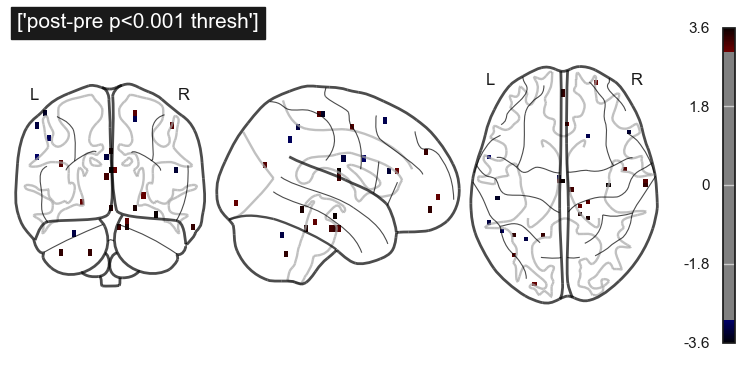

In [270]:
# controls post-pre 

#Making contrasts! 
contrast_matrix = np.eye(controls_prevpost_sldm.shape[1])
basic_contrasts = {
    column: contrast_matrix[i]
    for i, column in enumerate(controls_prevpost_sldm.columns)
    }

contrasts = {
     "post-pre": (basic_contrasts['session'])
    }      
contrasts

from nilearn.glm.second_level import SecondLevelModel

second_level_model = SecondLevelModel(n_jobs=2).fit(controls_prevpost.tolist(), design_matrix=controls_prevpost_sldm)

 # Iterate on contrasts
for contrast_id, contrast_val in contrasts.items():
    outputs = second_level_model.compute_contrast(contrast_val, output_type='all')

    plotting.plot_glass_brain(
        outputs['z_score'],
        threshold=p001_unc,
        display_mode="ortho",
        title=[contrast_id+" p<0.001 thresh"],
        plot_abs=False,
        colorbar=True
        )
    plotting.show()

In [271]:
#TFCE - non-parametric cluster correction

from nilearn.glm.second_level import non_parametric_inference

out_dict_controls_prevpost = non_parametric_inference(
    controls_prevpost.tolist(),
    design_matrix=controls_prevpost_sldm,
    second_level_contrast=contrast_val.tolist(),
    n_perm=10000,  # 500 for the sake of time. Ideally, this should be 10,000.
    two_sided_test=True,
    smoothing_fwhm=8.0,
    tfce=True,
    #mask=dmn_avg_mask,
    threshold=0.001,
)

KeyboardInterrupt: 

In [ ]:
# Load your TFCE result NIfTI file (replace 'result_file.nii.gz' with your actual file path)
result_img = out_dict_controls_prevpost['tfce'] 
# Plotting the TFCE map
plotting.plot_glass_brain(result_img, threshold=0.001, title='TFCE Results', display_mode='ortho',plot_abs=False,
                       colorbar=True)

plt.show()

logp_max_tfce_img = out_dict_controls_prevpost['logp_max_tfce']

threshold = -np.log10(0.001)  # p<0.001 corrected

# Plotting the logp_max_tfce map
plotting.plot_glass_brain(logp_max_tfce_img, threshold=threshold, title='Log P Max TFCE', display_mode='ortho',plot_abs=False,
                        colorbar=True)

# Display the plot
plt.show()